In [ ]:
#imports
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib
matplotlib.use('nbagg')
import numpy as np
import scipy as sp
from scipy import sparse
import matplotlib.pyplot as plt
#from scipy import special
from random import gauss
#import hdf5storage
import h5py
import timeit
from numba import jit
#from sympy.solvers.solveset import nonlinsolve
#from sympy.core.symbol import symbols
#from sympy import exp
from scipy import stats
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from core.analysis import *
from core.simulation import *


In [ ]:
#this function reconstruct some necessary fiber properties from the 'Fibers' and saves them to file
#note that the function is set to utilize the data in 'fgCC', following selen's instruction
#however, another fiber dataset is present inside 'Fibers', called 'fg'.
#the other dataset can be selected manually from inside the function
construct_fibers_from_data(
                #data from Selen Atasoy
                filepath_data='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat',
                filepath_Fibers='G:/Macbook Stuff/Downloads/Fibers.mat',
                           
                savefiles=True,
                bundle_size=7,
                output_filepath_fiber_edges='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_bundles.npy',
                output_filepath_fiber_lengths='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_lengths.npy',                       
                output_filepath_fiber_dist_starts='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_starts.npy',
                output_filepath_fiber_dist_ends='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_ends.npy',
                output_filepath_fiber_ends='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_ends.npy')    

In [ ]:
#this function reconstruct the mesh + DTI adjacency directly from the 'faces' and 'fibers' datasets
#the subcortical nodes and edges are excluded at the end of the procedure
#if the 'visual' option is selected, the function also returns datasets in suitable format for plotly
mesh_DTI_adjacency, Xn, Yn, Zn, iN, jN, kN,  Xe, Ye, Ze = construct_adjacency_matrix_from_data(
                                #data from Selen Atasoy
                                filepath_data='G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat',
                                
                                #results of previous cell
                                filepath_fiber_edges=['G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_edges.npy'],#,'G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_edges.npy'],
                                filepath_fiber_lengths=['G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_lengths.npy'],#,'G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_lengths.npy'],
                                filepath_fiber_ends=['G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_ends.npy'],#,'G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_ends.npy'],
                                
                                include_subcortex=False,
                                add_DTI=True,
                                fiber_speed_factor=200,
    
                                threshold=False,
                                max_dist=10,
                                filepath_fiber_dist_starts=['G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_dist_starts.npy'],#,'G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_starts.npy'],
                                filepath_fiber_dist_ends=['G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_dist_ends.npy'],#,'G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_ends.npy'],

                                visual=True,
                                plot_subcortex=False,
                                plot_DTI_edges=False)

In [ ]:
#len(np.nonzero(mesh_DTI_adjacency.toarray())[0])/2
#np.shape(mesh_DTI_adjacency.toarray())
f = h5py.File('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
indices = np.array([elem[0] for elem in CC])-1
AllVet=np.asarray(f['vertices']['all'])

u_0=np.heaviside(AllVet[0,indices],0)

#no_sub=mesh_DTI_adjacency[indices,:]
#no_sub=no_sub[:,indices]
#len(np.nonzero(no_sub.toarray())[0])/2
#mesh_DTI_adjacency=np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/metric_cortical_DTI_bundles_full_all_fibers.npy')
#mesh_DTI_adjacency=mesh_DTI_adjacency[indices,:]
#mesh_DTI_adjacency=mesh_DTI_adjacency[:,indices]
#mesh_DTI_adjacency.toarray().shape

In [ ]:
#np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/metric_cortical_DTI_bundles_full_all_fibers.npy', mesh_DTI_adjacency)

In [ ]:
#construct graph Laplacian and diagonalize it
#this is the same procedure used for regular graphs
AdjMatrix=mesh_DTI_adjacency.toarray()
AdjMatrix*=1000000
Deg=np.sum(AdjMatrix, axis=0)
Degree_Matrix=sp.sparse.diags(Deg)
regLap = Degree_Matrix - sp.sparse.csc_matrix(AdjMatrix)
Laplacian=-regLap.toarray()

vecs=True

if vecs==False:    
    eigenvalues=np.linalg.eigvalsh(Laplacian)
    eigenvalues[-1]=0
    eigenvalues=eigenvalues[::-1]
    np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_full_200short.npy', eigenvalues)
else:
    eigenvalues,eigenvectors=np.linalg.eigh(Laplacian)
    #eigenvalues[-1]=0
    #note that the eigenvectors come out 2-normalized
    eigenvalues=eigenvalues[::-1]
    eigenvectors=eigenvectors[:,::-1]
    np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_fgCC_200short_metres.npy', eigenvalues)
    np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs_DTI_fgCC_200short_metres.npy', eigenvectors)


In [ ]:
#Alternatively, if previously known, read eigenvalues and eigenvectors from file
#this is what i used for the thesis. note that it has to be loaded with a minus sign
#eigenvalues_thesis = -np.load('E:/My Documents/Dropbox/Amsterdam Math/Rikkert Hindriks/Graph-Stochastic-Wilson-Cowan-Model/data/eigvals.npy')
#this should be the corresponding eigenvectors. they appear to be 1-normalized
#eigenvectors_thesis = -np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs.npy')


eigenvalues = np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_fgCC_200short.npy')
#eigenvalues = np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_fgCC_200short_metres.npy')
#eigenvectors = np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs_DTI_fgCC_200short.npy')
#eigenvalues = -np.load('E:/My Documents/Dropbox/Amsterdam Math/Rikkert Hindriks/Graph-Stochastic-Wilson-Cowan-Model/data/eigvals.npy')


print(eigenvalues)
#print(eigenvalues2)

<IPython.core.display.Javascript object>


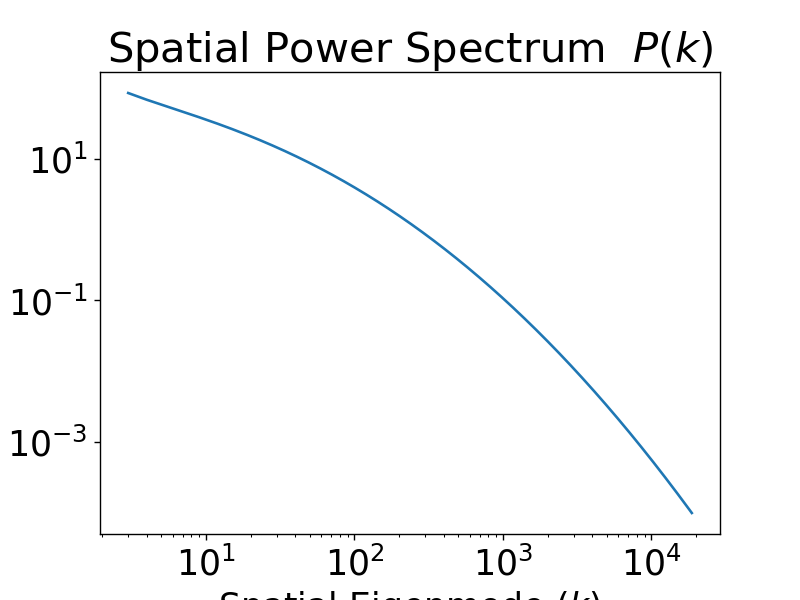

<IPython.core.display.Javascript object>


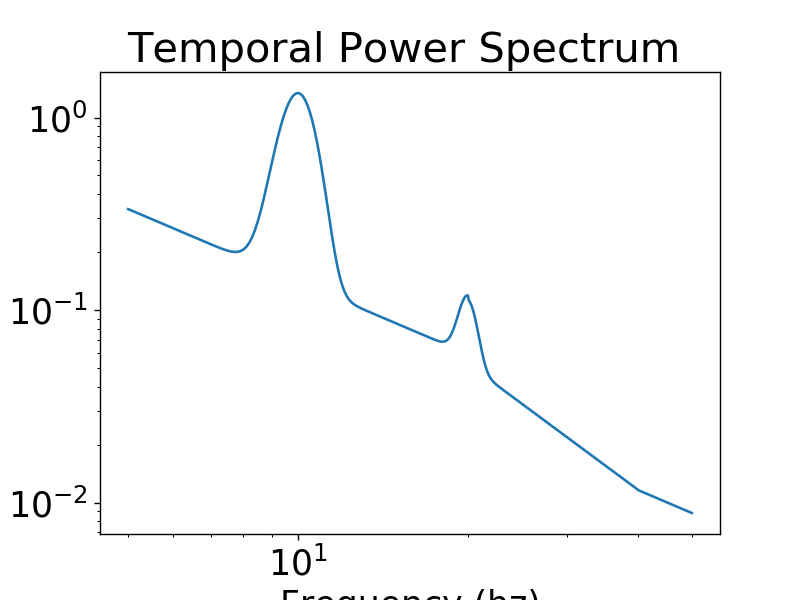

In [110]:
#Set parameters and bounds for minimization algorithms
aEE, bnds_aEE = 140, (1e-15,1e15)
aIE, bnds_aIE = 155, (1e-15,1e15)
aEI, bnds_aEI = 165, (1e-15,1e15)
aII, bnds_aII = 140, (1e-15,1e15)
dE, bnds_dE = 2, (1e-15,1e15)
dI, bnds_dI = 2, (1e-15,1e15)
P, bnds_P = 0, (0,1e15)
Q, bnds_Q = 0, (0,1e15)
sEE, bnds_sEE = 6, (1e-15,1e15)
sIE, bnds_sIE = 10, (1e-15,1e15)
sEI, bnds_sEI = 10, (1e-15,1e15)
sII, bnds_sII = 50, (1e-15,1e15)
D, bnds_D = 1, (0.1,10)             #unchanged
tE, bnds_tE = 1, (1e-15,1e15)          
tI, bnds_tI = 1, (1e-15,1e15)          
#snE, bnds_snE = 1, (1,10)        #unchanged
#snI, bnds_snI = 1, (1,10)         #unchanged


initial_guess=np.array([aEE,aIE,aEI,aII,dE,dI,P,Q,sEE,sIE,sEI,sII,tE,tI])#,snE])#,snI]) 
bnds=[bnds_aEE,bnds_aIE,bnds_aEI,bnds_aII,bnds_dE,bnds_dI,bnds_P,bnds_Q,bnds_sEE,bnds_sIE,bnds_sEI,bnds_sII,bnds_tE,bnds_tI]#,bnds_snE]#,bnds_snI]

Graph_Kernel='Gaussian'

#thesis values
first_k=2
last_k=5000
thesis_spatial_spectrum = 15*(np.arange(first_k,last_k)**(-0.3))

first_k=3
last_k=len(eigenvalues)
x_t = np.log(np.arange(first_k,last_k))
new_spatial_spectrum = 10**(-0.012*x_t**(2.2) + 0.6 + 0.5*x_t**(-0.3))#0.02*x_t**(1.1)+1.1)# + x_t**(-1.5)+10)

#more similar to fluctuations power data from selen
new_spatial_spectrum = 10**(-0.018*x_t**(2.2) + 0.5 + 0.5*x_t**(-0.3))

True_Spatial_Spectrum = new_spatial_spectrum**2

plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Spatial Power Spectrum  $P(k)$")
ax.set_xlabel("Spatial Eigenmode ($k$)")
ax.loglog(np.arange(first_k,last_k), True_Spatial_Spectrum)
         


LSA=True
Visual=False
SaveFiles=False
FilePath=' '

Min_omega=5*(2*np.pi)
Max_omega=50*(2*np.pi)
Delta_omega=0.1*(2*np.pi)
freqs=np.arange(Min_omega,Max_omega,Delta_omega)/(2*np.pi)

#higher gaussian TPS
higher_gaussian_TPS=100000/(100*freqs+10000)+5*np.exp((-(freqs-10)**2)/(2*0.9**2))
#lower gaussian TPS
lower_gaussian_TPS=100000/(100*freqs+10000)+3*np.exp((-(freqs-10)**2)/(2*1.2**2)) #too complex: 10*(1/(0.1*freqs+0.4)+0.7*np.exp((-(freqs-10)**2)/(2*0.9**2))+0.3*np.exp((-(freqs-22)**2)/(2*3**2)))
#even lower gaussian TPS
even_lower_gaussian_TPS=100000/(100*freqs+10000)+1.5*np.exp((-(freqs-10)**2)/(2*1.8**2))
#lowest gaussian TPS
lowest_gaussian_TPS=100000/(100*freqs+10000)+0.5*np.exp((-(freqs-10)**2)/(2*2.5**2))
#no gaussian TPS
no_gaussian_TPS=100000/(100*freqs+10000)

#new TPS, inspired by ketamine paper. suitable for loglog plotting, so multiplicative factor
new_TPS=2.5*freqs**(-1.25)+1.2*np.exp((-(freqs-10)**2)/(2*0.7**2)) + 0.06*np.exp((-(freqs-20)**2)/(2*0.7**2))
new_TPS[np.where((freqs>20) & (freqs<=40))] = 35*freqs[np.where((freqs>20) & (freqs<=40))]**(-2.17) +0.06*np.exp((-(freqs[np.where((freqs>20) & (freqs<=40))]-20)**2)/(2*0.7**2))
new_TPS[np.where(freqs>40)] = 1.17*freqs[np.where(freqs>40)]**(-1.25)

True_Temporal_Spectrum=new_TPS#[int(len(new_TPS)*0.1):int(len(new_TPS)*0.5)]
#Max_omega=25*(2*np.pi)


fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.set_title("Temporal Power Spectrum ")
ax.set_xlabel("Frequency (hz)")
ax.loglog(freqs, True_Temporal_Spectrum)

#change none to True_Spatial_Spectrum if want to fit to both
Args = (eigenvalues, Graph_Kernel, True_Temporal_Spectrum, Min_omega, Max_omega, Delta_omega, True_Spatial_Spectrum, first_k, LSA, Visual, SaveFiles)

In [ ]:
############################
#single analysis for easy visualization (note that if there are multiple stedy states the visualization will refer to the best one)
better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
       4.95497870e+00, 4.47579295e+00]))

aEE=115
aIE=175
aEI=190 
aII=210
dE=2.5 
dI=1 
P=0 
Q=0 
sEE=5.5 
sIE=3
sEI=3.5 
sII=100 
tE=1.2
tI=0.8
initial_guess=np.array([aEE,aIE,aEI,aII,dE,dI,P,Q,sEE,sIE,sEI,sII,tE,tI])
Full_Analysis(better_result['x'], eigenvalues, Graph_Kernel, True_Temporal_Spectrum, Max_omega, Delta_omega, True_Spatial_Spectrum, first_k, LSA, Visual, SaveFiles)

In [107]:
############################
#simple attempt at power spectrum fitting with a minimization algorithm. May get stuck in local minima.
#playing around with tolerance and max number of iterations is often necessary, depending on initial conditions. e.g.
#First run with fairly random initial guess: tol=1e-03, no maxiter (will take a while)
#Run starting from a previously obtained result: tol=1e-08, 'maxiter':2000

initial_guess=np.load('decent_spatiotemporal_spectrum_first_new_realistic.npy')[()]['x']

result = sp.optimize.minimize(Full_Analysis, initial_guess, args=Args,
                              method='trust-constr', 
                              bounds=bnds, 
                              #tol=1e-16,
                              options={#'ftol':1e-17,
                                        #  'maxls': 60,
                                       'disp':True})

E*=0.0081, I*=0.1006: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008128 Iss=0.1006.
Dist spatial: 29.03, scale: *60.73. +-1.307 
Dist temporal: 1.878, scale: *0.1271 +-0.4099

E*=0.0081, I*=0.1006: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008128 Iss=0.1006.
Dist spatial: 29.03, scale: *60.73. +-1.307 
Dist temporal: 1.878, scale: *0.1271 +-0.4099

E*=0.0081, I*=0.1006: unstable
No suitable (LSA) steady states found
E*=0.0081, I*=0.1006: unstable
No suitable (LSA) steady states found
E*=0.0081, I*=0.1006: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008128 Iss=0.1006.
Dist spatial: 29.03, scale: *60.73. +-1.307 
Dist temporal: 1.878, scale: *0.1271 +-0.4099

E*=0.0081, I*=0.1006: unstable
No suitable (LSA) steady states found
E*=0.0081, I*=0.1006: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008128 Iss=0.1006.
Dist spatial: 29.

Best suitable steady state: 0, with Ess=0.008643 Iss=0.1004.
Dist spatial: 141.4, scale: *218.4. +-4.651 
Dist temporal: 4.017, scale: *0.2099 +-0.6153

E*=0.0086, I*=0.1004: strictly stable
Best suitable steady state: 0, with Ess=0.008643 Iss=0.1004.
Dist spatial: 141.4, scale: *218.4. +-4.651 
Dist temporal: 4.017, scale: *0.2099 +-0.6153

E*=0.0086, I*=0.1004: strictly stable
Best suitable steady state: 0, with Ess=0.008643 Iss=0.1004.
Dist spatial: 141.4, scale: *218.4. +-4.651 
Dist temporal: 4.017, scale: *0.2099 +-0.6153

E*=0.0086, I*=0.1004: strictly stable
Best suitable steady state: 0, with Ess=0.008643 Iss=0.1004.
Dist spatial: 141.4, scale: *218.4. +-4.651 
Dist temporal: 4.017, scale: *0.2099 +-0.6153

E*=0.0086, I*=0.1004: strictly stable
Best suitable steady state: 0, with Ess=0.008643 Iss=0.1004.
Dist spatial: 141.4, scale: *218.4. +-4.651 
Dist temporal: 4.017, scale: *0.2099 +-0.6153

E*=0.0086, I*=0.1004: strictly stable
Best suitable steady state: 0, with Ess=0.008

Best suitable steady state: 0, with Ess=0.008567 Iss=0.1003.
Dist spatial: 136.7, scale: *195.4. +-4.205 
Dist temporal: 3.995, scale: *0.2047 +-0.6066

E*=0.0086, I*=0.1003: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008567 Iss=0.1003.
Dist spatial: 136.7, scale: *195.4. +-4.205 
Dist temporal: 3.995, scale: *0.2047 +-0.6066

E*=0.0086, I*=0.1003: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008567 Iss=0.1003.
Dist spatial: 136.7, scale: *195.4. +-4.205 
Dist temporal: 3.995, scale: *0.2047 +-0.6066

E*=0.0086, I*=0.1003: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008567 Iss=0.1003.
Dist spatial: 136.7, scale: *195.4. +-4.205 
Dist temporal: 3.995, scale: *0.2047 +-0.6066

E*=0.0085, I*=0.1001: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008455 Iss=0.1001.
Dist spatial: 127.4, scale: *164.5. +-3.595 
Dist temporal: 3.944, scal

E*=0.0070, I*=0.0954: unstable
No suitable (LSA) steady states found
E*=0.0070, I*=0.0954: unstable
No suitable (LSA) steady states found
E*=0.0070, I*=0.0954: unstable
No suitable (LSA) steady states found
E*=0.0070, I*=0.0954: unstable
No suitable (LSA) steady states found
E*=0.0070, I*=0.0954: unstable
No suitable (LSA) steady states found
E*=0.0070, I*=0.0954: unstable
No suitable (LSA) steady states found
E*=0.0070, I*=0.0954: unstable
No suitable (LSA) steady states found
E*=0.0070, I*=0.0954: unstable
No suitable (LSA) steady states found
E*=0.0070, I*=0.0954: unstable
No suitable (LSA) steady states found
E*=0.0070, I*=0.0954: unstable
No suitable (LSA) steady states found
E*=0.0070, I*=0.0954: unstable
No suitable (LSA) steady states found
E*=0.0070, I*=0.0954: unstable
No suitable (LSA) steady states found
E*=0.0070, I*=0.0954: unstable
No suitable (LSA) steady states found
E*=0.0070, I*=0.0954: unstable
No suitable (LSA) steady states found
E*=0.0070, I*=0.0954: unstable
No 

Best suitable steady state: 0, with Ess=0.00824 Iss=0.09958.
Dist spatial: 88.21, scale: *105.8. +-2.378 
Dist temporal: 3.717, scale: *0.1621 +-0.508

E*=0.0082, I*=0.0996: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.00824 Iss=0.09958.
Dist spatial: 88.21, scale: *105.8. +-2.378 
Dist temporal: 3.717, scale: *0.1621 +-0.508

E*=0.0082, I*=0.0996: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.00824 Iss=0.09958.
Dist spatial: 88.21, scale: *105.8. +-2.378 
Dist temporal: 3.717, scale: *0.1621 +-0.508

E*=0.0082, I*=0.0996: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.00824 Iss=0.09958.
Dist spatial: 88.21, scale: *105.8. +-2.378 
Dist temporal: 3.717, scale: *0.1621 +-0.508

E*=0.0082, I*=0.0996: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.00824 Iss=0.09958.
Dist spatial: 88.21, scale: *105.8. +-2.378 
Dist temporal: 3.717, scale: *

Best suitable steady state: 0, with Ess=0.008237 Iss=0.09957.
Dist spatial: 87.1, scale: *104.8. +-2.356 
Dist temporal: 3.713, scale: *0.1611 +-0.5052

E*=0.0082, I*=0.0996: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008237 Iss=0.09957.
Dist spatial: 87.1, scale: *104.8. +-2.356 
Dist temporal: 3.713, scale: *0.1611 +-0.5052

E*=0.0082, I*=0.0996: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008237 Iss=0.09957.
Dist spatial: 87.1, scale: *104.8. +-2.356 
Dist temporal: 3.713, scale: *0.1611 +-0.5052

E*=0.0082, I*=0.0996: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008237 Iss=0.09957.
Dist spatial: 87.1, scale: *104.8. +-2.356 
Dist temporal: 3.713, scale: *0.1611 +-0.5052

E*=0.0082, I*=0.0996: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008235 Iss=0.09956.
Dist spatial: 86.49, scale: *104.2. +-2.344 
Dist temporal: 3.711, sca

Best suitable steady state: 0, with Ess=0.008232 Iss=0.09955.
Dist spatial: 85.23, scale: *103.1. +-2.32 
Dist temporal: 3.707, scale: *0.1594 +-0.5002

E*=0.0082, I*=0.0996: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008232 Iss=0.09955.
Dist spatial: 85.23, scale: *103.1. +-2.32 
Dist temporal: 3.707, scale: *0.1594 +-0.5002

E*=0.0082, I*=0.0996: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008232 Iss=0.09955.
Dist spatial: 85.23, scale: *103.1. +-2.32 
Dist temporal: 3.707, scale: *0.1594 +-0.5002

E*=0.0082, I*=0.0996: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008232 Iss=0.09955.
Dist spatial: 85.23, scale: *103.1. +-2.32 
Dist temporal: 3.707, scale: *0.1594 +-0.5002

E*=0.0082, I*=0.0996: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008232 Iss=0.09955.
Dist spatial: 85.23, scale: *103.1. +-2.32 
Dist temporal: 3.707, scal

Best suitable steady state: 0, with Ess=0.008228 Iss=0.09955.
Dist spatial: 83.87, scale: *101.9. +-2.294 
Dist temporal: 3.702, scale: *0.1581 +-0.4965

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008228 Iss=0.09955.
Dist spatial: 83.87, scale: *101.9. +-2.294 
Dist temporal: 3.702, scale: *0.1581 +-0.4965

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008228 Iss=0.09955.
Dist spatial: 83.87, scale: *101.9. +-2.294 
Dist temporal: 3.702, scale: *0.1581 +-0.4965

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008226 Iss=0.09954.
Dist spatial: 83.15, scale: *101.3. +-2.28 
Dist temporal: 3.7, scale: *0.1574 +-0.4945

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008226 Iss=0.09954.
Dist spatial: 83.15, scale: *101.3. +-2.28 
Dist temporal: 3.7, scale

Best suitable steady state: 0, with Ess=0.008222 Iss=0.09953.
Dist spatial: 81.65, scale: *99.99. +-2.253 
Dist temporal: 3.696, scale: *0.156 +-0.4902

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008222 Iss=0.09953.
Dist spatial: 81.65, scale: *99.99. +-2.253 
Dist temporal: 3.696, scale: *0.156 +-0.4902

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008222 Iss=0.09953.
Dist spatial: 81.65, scale: *99.99. +-2.253 
Dist temporal: 3.696, scale: *0.156 +-0.4902

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008222 Iss=0.09953.
Dist spatial: 81.65, scale: *99.99. +-2.253 
Dist temporal: 3.696, scale: *0.156 +-0.4902

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008222 Iss=0.09953.
Dist spatial: 81.65, scale: *99.99. +-2.253 
Dist temporal: 3.696, sca

Best suitable steady state: 0, with Ess=0.008218 Iss=0.09952.
Dist spatial: 80.09, scale: *98.68. +-2.224 
Dist temporal: 3.692, scale: *0.1545 +-0.4856

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008218 Iss=0.09952.
Dist spatial: 80.09, scale: *98.68. +-2.224 
Dist temporal: 3.692, scale: *0.1545 +-0.4856

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008216 Iss=0.09952.
Dist spatial: 79.26, scale: *98. +-2.209 
Dist temporal: 3.691, scale: *0.1537 +-0.4832

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008216 Iss=0.09952.
Dist spatial: 79.26, scale: *98. +-2.209 
Dist temporal: 3.691, scale: *0.1537 +-0.4832

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008216 Iss=0.09952.
Dist spatial: 79.26, scale: *98. +-2.209 
Dist temporal: 3.691, scale: *

Best suitable steady state: 0, with Ess=0.008212 Iss=0.09951.
Dist spatial: 77.44, scale: *96.53. +-2.177 
Dist temporal: 3.687, scale: *0.1519 +-0.4776

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008212 Iss=0.09951.
Dist spatial: 77.44, scale: *96.53. +-2.177 
Dist temporal: 3.687, scale: *0.1519 +-0.4776

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008212 Iss=0.09951.
Dist spatial: 77.44, scale: *96.53. +-2.177 
Dist temporal: 3.687, scale: *0.1519 +-0.4776

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008212 Iss=0.09951.
Dist spatial: 77.44, scale: *96.53. +-2.177 
Dist temporal: 3.687, scale: *0.1519 +-0.4776

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008212 Iss=0.09951.
Dist spatial: 77.44, scale: *96.53. +-2.177 
Dist temporal: 3.687,

Best suitable steady state: 0, with Ess=0.008206 Iss=0.09949.
Dist spatial: 74.42, scale: *94.15. +-2.125 
Dist temporal: 3.684, scale: *0.1488 +-0.4679

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008206 Iss=0.09949.
Dist spatial: 74.42, scale: *94.15. +-2.125 
Dist temporal: 3.684, scale: *0.1488 +-0.4679

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008206 Iss=0.09949.
Dist spatial: 74.42, scale: *94.15. +-2.125 
Dist temporal: 3.684, scale: *0.1488 +-0.4679

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008206 Iss=0.09949.
Dist spatial: 74.42, scale: *94.15. +-2.125 
Dist temporal: 3.684, scale: *0.1488 +-0.4679

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008206 Iss=0.09949.
Dist spatial: 74.42, scale: *94.15. +-2.125 
Dist temporal: 3.684,

Best suitable steady state: 0, with Ess=0.008201 Iss=0.09948.
Dist spatial: 72.05, scale: *92.34. +-2.085 
Dist temporal: 3.683, scale: *0.1463 +-0.46

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008201 Iss=0.09948.
Dist spatial: 72.05, scale: *92.34. +-2.085 
Dist temporal: 3.683, scale: *0.1463 +-0.46

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008201 Iss=0.09948.
Dist spatial: 72.05, scale: *92.34. +-2.085 
Dist temporal: 3.683, scale: *0.1463 +-0.46

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008201 Iss=0.09948.
Dist spatial: 72.05, scale: *92.34. +-2.085 
Dist temporal: 3.683, scale: *0.1463 +-0.46

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008201 Iss=0.09948.
Dist spatial: 72.05, scale: *92.34. +-2.085 
Dist temporal: 3.683, scale: 

Best suitable steady state: 0, with Ess=0.008193 Iss=0.09946.
Dist spatial: 68.06, scale: *89.39. +-2.02 
Dist temporal: 3.684, scale: *0.142 +-0.4459

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008193 Iss=0.09946.
Dist spatial: 68.06, scale: *89.39. +-2.02 
Dist temporal: 3.684, scale: *0.142 +-0.4459

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008193 Iss=0.09946.
Dist spatial: 68.06, scale: *89.39. +-2.02 
Dist temporal: 3.684, scale: *0.142 +-0.4459

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008193 Iss=0.09946.
Dist spatial: 68.06, scale: *89.39. +-2.02 
Dist temporal: 3.684, scale: *0.142 +-0.4459

E*=0.0082, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008193 Iss=0.09946.
Dist spatial: 68.06, scale: *89.39. +-2.02 
Dist temporal: 3.684, scale: *

Best suitable steady state: 0, with Ess=0.008188 Iss=0.09944.
Dist spatial: 64.99, scale: *87.19. +-1.972 
Dist temporal: 3.688, scale: *0.1385 +-0.4344

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008188 Iss=0.09944.
Dist spatial: 64.99, scale: *87.19. +-1.972 
Dist temporal: 3.688, scale: *0.1385 +-0.4344

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008188 Iss=0.09944.
Dist spatial: 64.99, scale: *87.19. +-1.972 
Dist temporal: 3.688, scale: *0.1385 +-0.4344

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008188 Iss=0.09944.
Dist spatial: 64.99, scale: *87.19. +-1.972 
Dist temporal: 3.688, scale: *0.1385 +-0.4344

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008188 Iss=0.09944.
Dist spatial: 64.99, scale: *87.19. +-1.972 
Dist temporal: 3.688,

Best suitable steady state: 0, with Ess=0.008179 Iss=0.09942.
Dist spatial: 59.72, scale: *83.54. +-1.89 
Dist temporal: 3.702, scale: *0.1322 +-0.4131

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008179 Iss=0.09942.
Dist spatial: 59.72, scale: *83.54. +-1.89 
Dist temporal: 3.702, scale: *0.1322 +-0.4131

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008179 Iss=0.09942.
Dist spatial: 59.72, scale: *83.54. +-1.89 
Dist temporal: 3.702, scale: *0.1322 +-0.4131

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008179 Iss=0.09942.
Dist spatial: 59.72, scale: *83.54. +-1.89 
Dist temporal: 3.702, scale: *0.1322 +-0.4131

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008179 Iss=0.09942.
Dist spatial: 59.72, scale: *83.54. +-1.89 
Dist temporal: 3.702, scal

Best suitable steady state: 0, with Ess=0.008173 Iss=0.0994.
Dist spatial: 55.54, scale: *80.72. +-1.827 
Dist temporal: 3.719, scale: *0.1269 +-0.3948

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008173 Iss=0.0994.
Dist spatial: 55.54, scale: *80.72. +-1.827 
Dist temporal: 3.719, scale: *0.1269 +-0.3948

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008173 Iss=0.0994.
Dist spatial: 55.54, scale: *80.72. +-1.827 
Dist temporal: 3.719, scale: *0.1269 +-0.3948

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008173 Iss=0.0994.
Dist spatial: 55.54, scale: *80.72. +-1.827 
Dist temporal: 3.719, scale: *0.1269 +-0.3948

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008173 Iss=0.0994.
Dist spatial: 55.54, scale: *80.72. +-1.827 
Dist temporal: 3.719, scal

Best suitable steady state: 0, with Ess=0.008162 Iss=0.09938.
Dist spatial: 47.99, scale: *75.72. +-1.714 
Dist temporal: 3.765, scale: *0.1165 +-0.358

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008162 Iss=0.09938.
Dist spatial: 47.99, scale: *75.72. +-1.714 
Dist temporal: 3.765, scale: *0.1165 +-0.358

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008162 Iss=0.09938.
Dist spatial: 47.99, scale: *75.72. +-1.714 
Dist temporal: 3.765, scale: *0.1165 +-0.358

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008162 Iss=0.09938.
Dist spatial: 47.99, scale: *75.72. +-1.714 
Dist temporal: 3.765, scale: *0.1165 +-0.358

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008162 Iss=0.09938.
Dist spatial: 47.99, scale: *75.72. +-1.714 
Dist temporal: 3.765, sca

Best suitable steady state: 0, with Ess=0.008155 Iss=0.09936.
Dist spatial: 41.87, scale: *71.58. +-1.62 
Dist temporal: 3.819, scale: *0.1069 +-0.3233

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008155 Iss=0.09936.
Dist spatial: 41.87, scale: *71.58. +-1.62 
Dist temporal: 3.819, scale: *0.1069 +-0.3233

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008155 Iss=0.09936.
Dist spatial: 41.87, scale: *71.58. +-1.62 
Dist temporal: 3.819, scale: *0.1069 +-0.3233

E*=0.0082, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008155 Iss=0.09936.
Dist spatial: 41.87, scale: *71.58. +-1.62 
Dist temporal: 3.819, scale: *0.1069 +-0.3233

E*=0.0082, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008151 Iss=0.09935.
Dist spatial: 38.78, scale: *69.39. +-1.569 
Dist temporal: 3.854, sca

Best suitable steady state: 0, with Ess=0.008127 Iss=0.09928.
Dist spatial: 32.87, scale: *51.1. +-1.144 
Dist temporal: 4.333, scale: *0.04267 +-0.07551

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008127 Iss=0.09928.
Dist spatial: 32.87, scale: *51.1. +-1.144 
Dist temporal: 4.333, scale: *0.04267 +-0.07552

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008127 Iss=0.09928.
Dist spatial: 32.87, scale: *51.1. +-1.144 
Dist temporal: 4.333, scale: *0.04267 +-0.07551

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008127 Iss=0.09928.
Dist spatial: 32.87, scale: *51.1. +-1.144 
Dist temporal: 4.333, scale: *0.04267 +-0.07551

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008127 Iss=0.09928.
Dist spatial: 32.87, scale: *51.1. +-1.144 
Dist temporal: 4.3

Best suitable steady state: 0, with Ess=0.008138 Iss=0.09931.
Dist spatial: 29.7, scale: *60.56. +-1.365 
Dist temporal: 4.042, scale: *0.07615 +-0.2079

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008138 Iss=0.09931.
Dist spatial: 29.7, scale: *60.56. +-1.365 
Dist temporal: 4.042, scale: *0.07615 +-0.2079

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008138 Iss=0.09931.
Dist spatial: 29.7, scale: *60.56. +-1.365 
Dist temporal: 4.042, scale: *0.07615 +-0.2079

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008138 Iss=0.09931.
Dist spatial: 29.7, scale: *60.56. +-1.365 
Dist temporal: 4.042, scale: *0.07615 +-0.2079

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008138 Iss=0.09931.
Dist spatial: 29.7, scale: *60.56. +-1.365 
Dist temporal: 4.042, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.0993.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.079, scale: *0.07162 +-0.1904

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0993.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.079, scale: *0.07162 +-0.1904

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0993.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.079, scale: *0.07162 +-0.1904

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0993.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.079, scale: *0.07162 +-0.1904

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0993.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.079, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.0993.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.079, scale: *0.07163 +-0.1904

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0993.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.079, scale: *0.07163 +-0.1904

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0993.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.079, scale: *0.07163 +-0.1904

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0993.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.079, scale: *0.07163 +-0.1904

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0993.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.079, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.0993.
Dist spatial: 29.17, scale: *59.22. +-1.334 
Dist temporal: 4.077, scale: *0.0719 +-0.1915

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0993.
Dist spatial: 29.17, scale: *59.22. +-1.334 
Dist temporal: 4.077, scale: *0.0719 +-0.1915

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0993.
Dist spatial: 29.17, scale: *59.22. +-1.334 
Dist temporal: 4.077, scale: *0.0719 +-0.1915

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0993.
Dist spatial: 29.17, scale: *59.22. +-1.334 
Dist temporal: 4.077, scale: *0.0719 +-0.1915

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0993.
Dist spatial: 29.17, scale: *59.22. +-1.334 
Dist temporal: 4.077, scal

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.22. +-1.334 
Dist temporal: 4.077, scale: *0.07191 +-0.1915

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.22. +-1.334 
Dist temporal: 4.077, scale: *0.07191 +-0.1915

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.22. +-1.334 
Dist temporal: 4.077, scale: *0.07191 +-0.1915

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.22. +-1.334 
Dist temporal: 4.077, scale: *0.07191 +-0.1915

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.22. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.079, scale: *0.07165 +-0.1905

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.079, scale: *0.07165 +-0.1905

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.079, scale: *0.07165 +-0.1905

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.079, scale: *0.07165 +-0.1905

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.078, scale: *0.07166 +-0.1905

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.078, scale: *0.07166 +-0.1905

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.078, scale: *0.07166 +-0.1905

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.078, scale: *0.07166 +-0.1905

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.22. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.076, scale: *0.07194 +-0.1916

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.076, scale: *0.07193 +-0.1916

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.076, scale: *0.07194 +-0.1916

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.076, scale: *0.07194 +-0.1916

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.076, scale: *0.07194 +-0.1916

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.076, scale: *0.07194 +-0.1916

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.076, scale: *0.07194 +-0.1916

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.078, scale: *0.07167 +-0.1906

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.078, scale: *0.07168 +-0.1906

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.078, scale: *0.07168 +-0.1906

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.078, scale: *0.07168 +-0.1906

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.078, scale: *0.07168 +-0.1906

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.078, scale: *0.07169 +-0.1906

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.078, scale: *0.07169 +-0.1906

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.075, scale: *0.07196 +-0.1917

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.075, scale: *0.07196 +-0.1917

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.075, scale: *0.07197 +-0.1917

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.075, scale: *0.07197 +-0.1917

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.075, scale: *0.07197 +-0.1917

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.075, scale: *0.07197 +-0.1917

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.075, scale: *0.07198 +-0.1918

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.077, scale: *0.0717 +-0.1907

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.077, scale: *0.07171 +-0.1907

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.077, scale: *0.0717 +-0.1907

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.07

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.077, scale: *0.07171 +-0.1907

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.077, scale: *0.07171 +-0.1907

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.077, scale: *0.07171 +-0.1907

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.077, scale: *0.07171 +-0.1907

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.14. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.075, scale: *0.072 +-0.1918

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.075, scale: *0.072 +-0.1918

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.075, scale: *0.07199 +-0.1918

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.075, scale: *0.072 +-0.1918

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.075, s

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.075, scale: *0.072 +-0.1919

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.075, scale: *0.072 +-0.1919

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.075, scale: *0.072 +-0.1919

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.075, scale: *0.072 +-0.1919

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.075, sca

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.077, scale: *0.07174 +-0.1908

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.077, scale: *0.07173 +-0.1908

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.077, scale: *0.07173 +-0.1908

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.077, scale: *0.07174 +-0.1908

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.077, scale: *0.07174 +-0.1909

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.077, scale: *0.07174 +-0.1909

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.077, scale: *0.07174 +-0.1909

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.077, scale: *0.07174 +-0.1909

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.074, scale: *0.07203 +-0.192

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.074, scale: *0.07203 +-0.192

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.074, scale: *0.07203 +-0.192

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.074, scale: *0.07203 +-0.192

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.074,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.074, scale: *0.07204 +-0.192

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.074, scale: *0.07204 +-0.192

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.074, scale: *0.07204 +-0.192

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.074, scale: *0.07204 +-0.192

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.074,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.076, scale: *0.07177 +-0.191

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.076, scale: *0.07177 +-0.191

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.076, scale: *0.07177 +-0.191

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.076, scale: *0.07177 +-0.191

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.076,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.076, scale: *0.07177 +-0.191

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.076, scale: *0.07177 +-0.191

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.076, scale: *0.07177 +-0.191

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.076, scale: *0.07177 +-0.191

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.074,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.073, scale: *0.07206 +-0.1921

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.073, scale: *0.07206 +-0.1921

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.073, scale: *0.07206 +-0.1921

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.073, scale: *0.07206 +-0.1921

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.23. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.073, scale: *0.07207 +-0.1922

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.073, scale: *0.07207 +-0.1922

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.073, scale: *0.07207 +-0.1922

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.076, scale: *0.07179 +-0.1911

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.076, scale: *0.0718 +-0.1911

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.076, scale: *0.0718 +-0.1911

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.076, scale: *0.0718 +-0.1911

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.076, scale: *0.0718 +-0.1911

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.076,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.075, scale: *0.0718 +-0.1911

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.075, scale: *0.0718 +-0.1911

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.073, scale: *0.0721 +-0.1922

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.073, scale: *0.0721 +-0.1922

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.073,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.073, scale: *0.0721 +-0.1923

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.073, scale: *0.0721 +-0.1923

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.073, scale: *0.0721 +-0.1923

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.073, scale: *0.0721 +-0.1923

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.073,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.073, scale: *0.07211 +-0.1923

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.075, scale: *0.07182 +-0.1912

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.075, scale: *0.07182 +-0.1912

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.075, scale: *0.07182 +-0.1912

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.075, scale: *0.07183 +-0.1912

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.075, scale: *0.07183 +-0.1912

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.075, scale: *0.07183 +-0.1912

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.075, scale: *0.07183 +-0.1912

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.072, scale: *0.07213 +-0.1924

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.072, scale: *0.07213 +-0.1924

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.072, scale: *0.07213 +-0.1924

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.072, scale: *0.07213 +-0.1924

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.072, scale: *0.07214 +-0.1924

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.072, scale: *0.07214 +-0.1924

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.072, scale: *0.07214 +-0.1924

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.072, scale: *0.07214 +-0.1924

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.074, scale: *0.07186 +-0.1913

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.074, scale: *0.07186 +-0.1913

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.074, scale: *0.07186 +-0.1913

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.074, scale: *0.07186 +-0.1913

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.074, scale: *0.07186 +-0.1914

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.074, scale: *0.07186 +-0.1914

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.074, scale: *0.07186 +-0.1914

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.074, scale: *0.07186 +-0.1914

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.071, scale: *0.07217 +-0.1925

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.071, scale: *0.07217 +-0.1925

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.071, scale: *0.07217 +-0.1925

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.071, scale: *0.07217 +-0.1925

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.071, scale: *0.07217 +-0.1926

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.071, scale: *0.07217 +-0.1926

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.071, scale: *0.07217 +-0.1926

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.071, scale: *0.07217 +-0.1926

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.074, scale: *0.07189 +-0.1915

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.074, scale: *0.07189 +-0.1915

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.074, scale: *0.07189 +-0.1915

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.074, scale: *0.07189 +-0.1915

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.073, scale: *0.0719 +-0.1915

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.073, scale: *0.0719 +-0.1915

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.073, scale: *0.0719 +-0.1915

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.073, scale: *0.0719 +-0.1915

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09931.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.071,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.071, scale: *0.07221 +-0.1927

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.071, scale: *0.07221 +-0.1927

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.071, scale: *0.07221 +-0.1927

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.071, scale: *0.07221 +-0.1927

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.24. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.07, scale: *0.07222 +-0.1927

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.07, scale: *0.07222 +-0.1927

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.07, scale: *0.07222 +-0.1927

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.073, scale: *0.07192 +-0.1916

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.073

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.073, scale: *0.07193 +-0.1916

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.073, scale: *0.07193 +-0.1916

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.073, scale: *0.07193 +-0.1916

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.073, scale: *0.07193 +-0.1916

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.073, scale: *0.07193 +-0.1916

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.15. +-1.332 
Dist temporal: 4.073, scale: *0.07193 +-0.1916

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.07, scale: *0.07225 +-0.1928

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.07, scale: *0.07225 +-0.1928

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.07

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.07, scale: *0.07225 +-0.1929

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.07, scale: *0.07225 +-0.1929

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.07, scale: *0.07225 +-0.1929

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.07, scale: *0.07225 +-0.1929

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.07, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.07, scale: *0.07226 +-0.1929

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.072, scale: *0.07196 +-0.1917

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.072, scale: *0.07196 +-0.1917

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.072, scale: *0.07196 +-0.1917

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.0

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.072, scale: *0.07197 +-0.1918

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.072, scale: *0.07196 +-0.1918

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.072, scale: *0.07196 +-0.1918

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.072, scale: *0.07196 +-0.1918

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.069, scale: *0.07229 +-0.193

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.069, scale: *0.07229 +-0.193

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.069, scale: *0.07229 +-0.193

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.069, scale: *0.07229 +-0.193

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.069,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.069, scale: *0.0723 +-0.1931

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.069, scale: *0.0723 +-0.1931

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.069, scale: *0.0723 +-0.1931

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.069, scale: *0.0723 +-0.1931

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.069,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.071, scale: *0.072 +-0.1919

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.071, scale: *0.07199 +-0.1919

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.071, scale: *0.072 +-0.1919

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.071, scale: *0.072 +-0.1919

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.071, s

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.071, scale: *0.072 +-0.1919

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.071, scale: *0.072 +-0.1919

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.071, scale: *0.072 +-0.1919

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.071, scale: *0.072 +-0.1919

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.071, sca

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.068, scale: *0.07233 +-0.1932

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.068, scale: *0.07233 +-0.1932

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.068, scale: *0.07233 +-0.1932

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.068, scale: *0.07233 +-0.1932

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.068, scale: *0.07234 +-0.1932

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.068, scale: *0.07234 +-0.1932

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.068, scale: *0.07234 +-0.1932

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.068, scale: *0.07234 +-0.1932

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.25. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.071, scale: *0.07203 +-0.192

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.071, scale: *0.07204 +-0.192

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.071, scale: *0.07203 +-0.192

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.071, scale: *0.07204 +-0.192

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.071,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.07, scale: *0.07204 +-0.1921

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.07, scale: *0.07204 +-0.1921

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.07, scale: *0.07204 +-0.1921

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.07, scale: *0.07204 +-0.1921

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.068,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.067, scale: *0.07238 +-0.1934

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.067, scale: *0.07238 +-0.1934

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.067, scale: *0.07238 +-0.1934

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.067, scale: *0.07238 +-0.1934

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.067, scale: *0.07239 +-0.1934

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.067, scale: *0.07239 +-0.1934

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.067, scale: *0.07239 +-0.1934

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.07, scale: *0.07207 +-0.1922

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.0

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.07, scale: *0.07208 +-0.1922

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.07, scale: *0.07208 +-0.1922

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.07, scale: *0.07208 +-0.1922

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.07, scale: *0.07208 +-0.1922

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.07, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.07, scale: *0.07208 +-0.1922

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.07, scale: *0.07208 +-0.1922

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.067, scale: *0.07242 +-0.1935

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.067, scale: *0.07242 +-0.1935

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.06

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.066, scale: *0.07243 +-0.1936

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.066, scale: *0.07243 +-0.1936

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.066, scale: *0.07243 +-0.1936

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.066, scale: *0.07243 +-0.1936

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.26. +-1.334 
Dist temporal: 4.066, scale: *0.07244 +-0.1936

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.069, scale: *0.07211 +-0.1923

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.069, scale: *0.07211 +-0.1923

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.069, scale: *0.07211 +-0.1923

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.069, scale: *0.07212 +-0.1924

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.069, scale: *0.07212 +-0.1924

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.069, scale: *0.07212 +-0.1924

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.069, scale: *0.07212 +-0.1924

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.066, scale: *0.07247 +-0.1937

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.066, scale: *0.07247 +-0.1937

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.066, scale: *0.07247 +-0.1937

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.066, scale: *0.07247 +-0.1937

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.065, scale: *0.07248 +-0.1938

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.065, scale: *0.07248 +-0.1938

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.065, scale: *0.07248 +-0.1938

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.065, scale: *0.07248 +-0.1938

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.068, scale: *0.07216 +-0.1925

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.068, scale: *0.07215 +-0.1925

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.068, scale: *0.07216 +-0.1925

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.068, scale: *0.07216 +-0.1925

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.068, scale: *0.07216 +-0.1926

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.068, scale: *0.07216 +-0.1926

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.068, scale: *0.07216 +-0.1926

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.068, scale: *0.07216 +-0.1926

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09932.
Dist spatial: 29.14, scale: *59.16. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.065, scale: *0.07253 +-0.194

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.065, scale: *0.07253 +-0.194

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.065, scale: *0.07253 +-0.194

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.065, scale: *0.07253 +-0.194

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.065,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.064, scale: *0.07254 +-0.194

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.064, scale: *0.07254 +-0.194

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.064, scale: *0.07254 +-0.194

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.064, scale: *0.07254 +-0.194

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.27. +-1.334 
Dist temporal: 4.064,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.067, scale: *0.0722 +-0.1927

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.067, scale: *0.0722 +-0.1927

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.067, scale: *0.0722 +-0.1927

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.067, scale: *0.0722 +-0.1927

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.067,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.067, scale: *0.07221 +-0.1928

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.067, scale: *0.07221 +-0.1928

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.067, scale: *0.07221 +-0.1928

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.067, scale: *0.07221 +-0.1928

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.063, scale: *0.07259 +-0.1942

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.063, scale: *0.07259 +-0.1942

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.063, scale: *0.07259 +-0.1942

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.063, scale: *0.07259 +-0.1942

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.063, scale: *0.07261 +-0.1943

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.063, scale: *0.07261 +-0.1943

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.063, scale: *0.07261 +-0.1943

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.066, scale: *0.07224 +-0.1929

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.066, scale: *0.07226 +-0.1929

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.066, scale: *0.07226 +-0.1929

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.066, scale: *0.07226 +-0.1929

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.066, scale: *0.07226 +-0.1929

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.066, scale: *0.07227 +-0.193

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.066, scale: *0.07227 +-0.193

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.062, scale: *0.07264 +-0.1944

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.062, scale: *0.07264 +-0.1944

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.06

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.062, scale: *0.07266 +-0.1945

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.062, scale: *0.07266 +-0.1945

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.062, scale: *0.07266 +-0.1945

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.062, scale: *0.07266 +-0.1945

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.28. +-1.334 
Dist temporal: 4.062, scale: *0.07267 +-0.1945

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.065, scale: *0.0723 +-0.1931

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.065, scale: *0.0723 +-0.1931

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.065, scale: *0.0723 +-0.1931

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.065

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.065, scale: *0.07231 +-0.1931

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.065, scale: *0.07231 +-0.1931

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.065, scale: *0.07231 +-0.1931

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.065, scale: *0.07231 +-0.1931

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.29. +-1.334 
Dist temporal: 4.061, scale: *0.07271 +-0.1947

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.29. +-1.334 
Dist temporal: 4.061, scale: *0.07271 +-0.1947

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.29. +-1.334 
Dist temporal: 4.061, scale: *0.07271 +-0.1947

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.29. +-1.334 
Dist temporal: 4.061, scale: *0.07271 +-0.1947

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.29. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.29. +-1.334 
Dist temporal: 4.061, scale: *0.07272 +-0.1947

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.29. +-1.334 
Dist temporal: 4.061, scale: *0.07272 +-0.1947

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.29. +-1.334 
Dist temporal: 4.061, scale: *0.07272 +-0.1947

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.29. +-1.334 
Dist temporal: 4.061, scale: *0.07272 +-0.1947

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.29. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.064, scale: *0.07236 +-0.1933

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.064, scale: *0.07236 +-0.1933

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.064, scale: *0.07236 +-0.1933

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.064, scale: *0.07236 +-0.1933

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.064, scale: *0.07237 +-0.1934

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.064, scale: *0.07237 +-0.1934

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.064, scale: *0.07237 +-0.1934

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.064, scale: *0.07237 +-0.1934

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.17. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.3. +-1.335 
Dist temporal: 4.06, scale: *0.0728 +-0.195

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.3. +-1.335 
Dist temporal: 4.06, scale: *0.0728 +-0.195

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.3. +-1.335 
Dist temporal: 4.06, scale: *0.0728 +-0.1951

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.3. +-1.335 
Dist temporal: 4.06, scale: *0.0728 +-0.195

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.3. +-1.335 
Dist temporal: 4.06, scale: *0.07

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.3. +-1.335 
Dist temporal: 4.059, scale: *0.07283 +-0.1951

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.3. +-1.335 
Dist temporal: 4.059, scale: *0.07283 +-0.1951

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.3. +-1.335 
Dist temporal: 4.059, scale: *0.07283 +-0.1951

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.3. +-1.335 
Dist temporal: 4.059, scale: *0.07283 +-0.1951

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.17, scale: *59.3. +-1.335 
Dist temporal: 4.059, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.062, scale: *0.07242 +-0.1936

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.062, scale: *0.07242 +-0.1936

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.062, scale: *0.07242 +-0.1936

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.062, scale: *0.07242 +-0.1936

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.062, scale: *0.07244 +-0.1936

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.062, scale: *0.07244 +-0.1936

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.062, scale: *0.07244 +-0.1936

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.062, scale: *0.07244 +-0.1936

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09933.
Dist spatial: 29.18, scale: *59.31. +-1.335 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.31. +-1.335 
Dist temporal: 4.058, scale: *0.07289 +-0.1954

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.31. +-1.335 
Dist temporal: 4.058, scale: *0.07289 +-0.1954

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.31. +-1.335 
Dist temporal: 4.058, scale: *0.0729 +-0.1954

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.31. +-1.335 
Dist temporal: 4.058, scale: *0.07289 +-0.1954

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.31. +-1.335 
Dist temporal: 4.0

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.31. +-1.335 
Dist temporal: 4.058, scale: *0.07291 +-0.1955

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.31. +-1.335 
Dist temporal: 4.058, scale: *0.07291 +-0.1955

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.31. +-1.335 
Dist temporal: 4.058, scale: *0.07291 +-0.1955

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.061, scale: *0.07248 +-0.1938

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.061, scale: *0.0725 +-0.1939

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.061, scale: *0.0725 +-0.1939

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.061, scale: *0.0725 +-0.1939

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.061, scale: *0.0725 +-0.1939

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.061,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.06, scale: *0.07251 +-0.1939

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.06, scale: *0.07251 +-0.1939

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.32. +-1.335 
Dist temporal: 4.056, scale: *0.07297 +-0.1957

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.32. +-1.335 
Dist temporal: 4.056, scale: *0.07297 +-0.1957

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.32. +-1.335 
Dist temporal: 4.05

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.32. +-1.335 
Dist temporal: 4.056, scale: *0.073 +-0.1958

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.32. +-1.335 
Dist temporal: 4.056, scale: *0.073 +-0.1958

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.32. +-1.335 
Dist temporal: 4.056, scale: *0.073 +-0.1958

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.32. +-1.335 
Dist temporal: 4.056, scale: *0.073 +-0.1958

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.32. +-1.335 
Dist temporal: 4.056, sca

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.32. +-1.335 
Dist temporal: 4.056, scale: *0.07302 +-0.1959

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.059, scale: *0.07256 +-0.1941

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.332 
Dist temporal: 4.059, scale: *0.07256 +-0.1941

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.059, scale: *0.07256 +-0.1941

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.059, scale: *0.07257 +-0.1942

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.059, scale: *0.07257 +-0.1942

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.059, scale: *0.07257 +-0.1942

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.059, scale: *0.07257 +-0.1942

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.32. +-1.335 
Dist temporal: 4.055, scale: *0.07305 +-0.1961

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.32. +-1.335 
Dist temporal: 4.055, scale: *0.07305 +-0.1961

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.32. +-1.335 
Dist temporal: 4.055, scale: *0.07305 +-0.196

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.32. +-1.335 
Dist temporal: 4.055, scale: *0.07305 +-0.1961

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.32. +-1.335 
Dist temporal: 4.0

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.33. +-1.335 
Dist temporal: 4.054, scale: *0.07309 +-0.1962

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.33. +-1.335 
Dist temporal: 4.054, scale: *0.07309 +-0.1962

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.33. +-1.335 
Dist temporal: 4.054, scale: *0.07309 +-0.1962

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.33. +-1.335 
Dist temporal: 4.054, scale: *0.07309 +-0.1962

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.33. +-1.335 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.058, scale: *0.07264 +-0.1945

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.058, scale: *0.07264 +-0.1945

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.058, scale: *0.07264 +-0.1945

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.058, scale: *0.07264 +-0.1945

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.057, scale: *0.07266 +-0.1945

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.057, scale: *0.07266 +-0.1945

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.057, scale: *0.07266 +-0.1945

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.057, scale: *0.07266 +-0.1945

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.14, scale: *59.18. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.34. +-1.335 
Dist temporal: 4.052, scale: *0.0732 +-0.1966

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.34. +-1.335 
Dist temporal: 4.052, scale: *0.0732 +-0.1966

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.34. +-1.335 
Dist temporal: 4.052, scale: *0.0732 +-0.1966

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.34. +-1.335 
Dist temporal: 4.052, scale: *0.0732 +-0.1966

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.18, scale: *59.34. +-1.335 
Dist temporal: 4.052,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.16, scale: *59.26. +-1.333 
Dist temporal: 4.054, scale: *0.07295 +-0.1957

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.16, scale: *59.26. +-1.333 
Dist temporal: 4.054, scale: *0.07295 +-0.1957

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.16, scale: *59.26. +-1.333 
Dist temporal: 4.054, scale: *0.07295 +-0.1957

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.16, scale: *59.26. +-1.333 
Dist temporal: 4.054, scale: *0.07295 +-0.1957

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.16, scale: *59.26. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.057, scale: *0.07269 +-0.1946

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.056, scale: *0.07269 +-0.1946

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.057, scale: *0.07269 +-0.1946

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.056, scale: *0.07269 +-0.1946

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.056, scale: *0.07269 +-0.1947

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.056, scale: *0.07269 +-0.1947

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.056, scale: *0.07269 +-0.1947

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.056, scale: *0.07269 +-0.1947

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.16, scale: *59.26. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.054, scale: *0.07298 +-0.1958

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.054, scale: *0.07298 +-0.1958

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.054, scale: *0.07298 +-0.1958

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.054, scale: *0.07298 +-0.1958

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.054, scale: *0.07299 +-0.1958

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.054, scale: *0.07299 +-0.1958

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.054, scale: *0.07299 +-0.1958

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.056, scale: *0.07271 +-0.1947

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.056, scale: *0.07272 +-0.1948

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.056, scale: *0.07272 +-0.1948

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.056, scale: *0.07272 +-0.1948

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.056, scale: *0.07272 +-0.1948

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.056, scale: *0.07272 +-0.1948

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09934.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.056, scale: *0.07272 +-0.1948

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.053, scale: *0.07301 +-0.1959

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.053, scale: *0.07301 +-0.1959

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.053, scale: *0.07302 +-0.1959

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.053, scale: *0.07302 +-0.1959

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.053, scale: *0.07302 +-0.1959

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.053, scale: *0.07302 +-0.1959

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.053, scale: *0.07303 +-0.196

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.055, scale: *0.07274 +-0.1949

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.055, scale: *0.07274 +-0.1949

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.055, scale: *0.07274 +-0.1949

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.0

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.055, scale: *0.07275 +-0.1949

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.055, scale: *0.07275 +-0.1949

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.055, scale: *0.07275 +-0.1949

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.055, scale: *0.07275 +-0.1949

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.052, scale: *0.07305 +-0.1961

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.052, scale: *0.07305 +-0.1961

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.052, scale: *0.07305 +-0.1961

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.052, scale: *0.07305 +-0.1961

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.052, scale: *0.07306 +-0.1961

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.052, scale: *0.07306 +-0.1961

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.052, scale: *0.07306 +-0.1961

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.052, scale: *0.07306 +-0.1961

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.055, scale: *0.07278 +-0.195

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.055, scale: *0.07277 +-0.195

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.055, scale: *0.07278 +-0.195

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.055, scale: *0.07278 +-0.195

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.055,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.054, scale: *0.07278 +-0.195

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.054, scale: *0.07278 +-0.195

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.054, scale: *0.07278 +-0.195

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.054, scale: *0.07278 +-0.195

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.054,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.052, scale: *0.07309 +-0.1962

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.052, scale: *0.07309 +-0.1962

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.052, scale: *0.07309 +-0.1962

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.052, scale: *0.07309 +-0.1962

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.052, scale: *0.07309 +-0.1962

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.052, scale: *0.07309 +-0.1962

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.052, scale: *0.07309 +-0.1962

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.052, scale: *0.0731 +-0.1962

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.0

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.054, scale: *0.07281 +-0.1951

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.054, scale: *0.07281 +-0.1951

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.054, scale: *0.07281 +-0.1951

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.054, scale: *0.07281 +-0.1951

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.054, scale: *0.07282 +-0.1952

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.054, scale: *0.07282 +-0.1952

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.054, scale: *0.07282 +-0.1952

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.18. +-1.331 
Dist temporal: 4.054, scale: *0.07282 +-0.1952

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.27. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.051, scale: *0.07312 +-0.1964

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.051, scale: *0.07312 +-0.1964

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.051, scale: *0.07312 +-0.1964

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.051, scale: *0.07312 +-0.1964

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.051, scale: *0.07313 +-0.1964

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.051, scale: *0.07313 +-0.1964

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.051, scale: *0.07313 +-0.1964

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.053, scale: *0.07284 +-0.1952

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.053, scale: *0.07284 +-0.1953

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.053, scale: *0.07284 +-0.1953

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.053, scale: *0.07284 +-0.1953

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.053, scale: *0.07284 +-0.1953

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.053, scale: *0.07285 +-0.1953

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.053, scale: *0.07285 +-0.1953

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.05, scale: *0.07316 +-0.1965

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.05, scale: *0.07316 +-0.1965

E*=0.0081, I*=0.0993: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.05

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.05, scale: *0.07316 +-0.1965

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.05, scale: *0.07316 +-0.1965

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.05, scale: *0.07316 +-0.1965

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.05, scale: *0.07316 +-0.1965

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.05, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.05, scale: *0.07317 +-0.1965

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.053, scale: *0.07287 +-0.1954

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.053, scale: *0.07287 +-0.1954

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.053, scale: *0.07287 +-0.1954

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.0

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.052, scale: *0.07288 +-0.1954

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.052, scale: *0.07288 +-0.1954

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.052, scale: *0.07288 +-0.1954

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.052, scale: *0.07288 +-0.1954

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.05, scale: *0.0732 +-0.1966

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.05, scale: *0.0732 +-0.1966

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.05, scale: *0.07319 +-0.1966

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.05, scale: *0.0732 +-0.1966

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.05, sca

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.049, scale: *0.0732 +-0.1967

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.049, scale: *0.0732 +-0.1967

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.049, scale: *0.0732 +-0.1967

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.049, scale: *0.0732 +-0.1967

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.049,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.052, scale: *0.07291 +-0.1955

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.052, scale: *0.07291 +-0.1955

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.052, scale: *0.07291 +-0.1955

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.052, scale: *0.07291 +-0.1955

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.052, scale: *0.07292 +-0.1956

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.052, scale: *0.07292 +-0.1956

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.052, scale: *0.07292 +-0.1956

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.052, scale: *0.07292 +-0.1956

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.049, scale: *0.07324 +-0.1968

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.049, scale: *0.07324 +-0.1968

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.049, scale: *0.07324 +-0.1968

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.049, scale: *0.07324 +-0.1968

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.049, scale: *0.07325 +-0.1968

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.049, scale: *0.07325 +-0.1968

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.049, scale: *0.07325 +-0.1968

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.049, scale: *0.07325 +-0.1969

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.28. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.051, scale: *0.07295 +-0.1957

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.051, scale: *0.07295 +-0.1957

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.051, scale: *0.07295 +-0.1957

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.051, scale: *0.07295 +-0.1957

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.051, scale: *0.07295 +-0.1957

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.051, scale: *0.07295 +-0.1957

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.051, scale: *0.07295 +-0.1957

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.051, scale: *0.07295 +-0.1957

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.048, scale: *0.07328 +-0.197

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.048, scale: *0.07328 +-0.197

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.048, scale: *0.07328 +-0.197

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.048, scale: *0.07328 +-0.197

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.048,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.048, scale: *0.07329 +-0.197

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.048, scale: *0.07329 +-0.197

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.048, scale: *0.07329 +-0.197

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.05, scale: *0.07298 +-0.1958

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.05, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.05, scale: *0.07298 +-0.1958

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.05, scale: *0.07298 +-0.1958

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.05, scale: *0.07298 +-0.1958

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.05, scale: *0.07298 +-0.1958

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.05, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.05, scale: *0.07299 +-0.1959

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.05, scale: *0.07299 +-0.1959

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.047, scale: *0.07331 +-0.1971

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.047, scale: *0.07331 +-0.1971

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09935.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.04

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.047, scale: *0.07332 +-0.1971

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.047, scale: *0.07332 +-0.1971

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.047, scale: *0.07332 +-0.1971

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.047, scale: *0.07332 +-0.1971

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.047, scale: *0.07333 +-0.1972

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.049, scale: *0.07301 +-0.196

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.049, scale: *0.07302 +-0.196

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.049, scale: *0.07301 +-0.196

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.049

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.049, scale: *0.07302 +-0.196

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.049, scale: *0.07302 +-0.196

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.049, scale: *0.07302 +-0.196

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.049, scale: *0.07302 +-0.196

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.049,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.046, scale: *0.07336 +-0.1973

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.046, scale: *0.07336 +-0.1973

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.046, scale: *0.07336 +-0.1973

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.046, scale: *0.07336 +-0.1973

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.046, scale: *0.07337 +-0.1973

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.046, scale: *0.07337 +-0.1973

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.046, scale: *0.07337 +-0.1973

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.046, scale: *0.07337 +-0.1973

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.049, scale: *0.07306 +-0.1961

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.049, scale: *0.07305 +-0.1961

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.049, scale: *0.07305 +-0.1961

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.049, scale: *0.07306 +-0.1961

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.048, scale: *0.07306 +-0.1961

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.048, scale: *0.07306 +-0.1961

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.048, scale: *0.07306 +-0.1961

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.048, scale: *0.07306 +-0.1961

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.19. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.045, scale: *0.0734 +-0.1975

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.045, scale: *0.0734 +-0.1975

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.045, scale: *0.0734 +-0.1975

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.045, scale: *0.0734 +-0.1975

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.045,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.045, scale: *0.07341 +-0.1975

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.045, scale: *0.07341 +-0.1975

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.045, scale: *0.07341 +-0.1975

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.045, scale: *0.07341 +-0.1975

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.29. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.048, scale: *0.0731 +-0.1963

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.048, scale: *0.0731 +-0.1963

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.048, scale: *0.0731 +-0.1963

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.048, scale: *0.0731 +-0.1963

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.048, scal

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.048, scale: *0.0731 +-0.1963

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.048, scale: *0.0731 +-0.1963

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.048, scale: *0.0731 +-0.1963

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.048, scale: *0.0731 +-0.1963

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.045, scal

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.044, scale: *0.07345 +-0.1977

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.044, scale: *0.07345 +-0.1977

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.044, scale: *0.07345 +-0.1977

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.044, scale: *0.07345 +-0.1977

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.044, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.044, scale: *0.07346 +-0.1977

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.044, scale: *0.07346 +-0.1977

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.044, scale: *0.07346 +-0.1977

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.047, scale: *0.07313 +-0.1964

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.047, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.047, scale: *0.07314 +-0.1965

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.047, scale: *0.07314 +-0.1965

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.047, scale: *0.07314 +-0.1965

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.047, scale: *0.07314 +-0.1965

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.047, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.047, scale: *0.07315 +-0.1965

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.047, scale: *0.07315 +-0.1965

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.044, scale: *0.07349 +-0.1978

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.044, scale: *0.07349 +-0.1978

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.044, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.043, scale: *0.0735 +-0.1979

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.043, scale: *0.0735 +-0.1979

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.043, scale: *0.0735 +-0.1979

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.043, scale: *0.0735 +-0.1979

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.043, scal

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.043, scale: *0.07351 +-0.1979

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.046, scale: *0.07317 +-0.1966

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.046, scale: *0.07318 +-0.1966

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.046, scale: *0.07317 +-0.1966

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.046, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.046, scale: *0.07318 +-0.1966

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.046, scale: *0.07318 +-0.1966

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.046, scale: *0.07318 +-0.1966

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.046, scale: *0.07318 +-0.1966

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.046, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.043, scale: *0.07355 +-0.198

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.043, scale: *0.07355 +-0.198

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.043, scale: *0.07354 +-0.198

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.043, scale: *0.07355 +-0.198

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.3. +-1.333 
Dist temporal: 4.043, scal

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.31. +-1.333 
Dist temporal: 4.042, scale: *0.07356 +-0.1981

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.31. +-1.333 
Dist temporal: 4.042, scale: *0.07356 +-0.1981

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.31. +-1.333 
Dist temporal: 4.042, scale: *0.07356 +-0.1981

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.31. +-1.333 
Dist temporal: 4.042, scale: *0.07356 +-0.1981

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.31. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.045, scale: *0.07322 +-0.1968

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.045, scale: *0.07322 +-0.1968

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.045, scale: *0.07322 +-0.1968

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.045, scale: *0.07322 +-0.1968

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.045, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.045, scale: *0.07323 +-0.1968

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.045, scale: *0.07323 +-0.1968

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.045, scale: *0.07323 +-0.1968

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.045, scale: *0.07323 +-0.1968

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.045, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.31. +-1.333 
Dist temporal: 4.041, scale: *0.0736 +-0.1982

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.31. +-1.333 
Dist temporal: 4.041, scale: *0.0736 +-0.1983

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.31. +-1.333 
Dist temporal: 4.041, scale: *0.0736 +-0.1983

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.31. +-1.333 
Dist temporal: 4.041, scale: *0.0736 +-0.1983

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.31. +-1.333 
Dist temporal: 4.041,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.31. +-1.333 
Dist temporal: 4.041, scale: *0.07361 +-0.1983

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.31. +-1.333 
Dist temporal: 4.041, scale: *0.07361 +-0.1983

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.31. +-1.333 
Dist temporal: 4.041, scale: *0.07361 +-0.1983

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.31. +-1.333 
Dist temporal: 4.041, scale: *0.07361 +-0.1983

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.16, scale: *59.31. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.044, scale: *0.07327 +-0.197

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.044, scale: *0.07327 +-0.197

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.044, scale: *0.07327 +-0.197

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.044, scale: *0.07327 +-0.197

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.044, scal

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.044, scale: *0.07328 +-0.197

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.044, scale: *0.07328 +-0.197

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.044, scale: *0.07328 +-0.197

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09936.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.044, scale: *0.07328 +-0.197

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.04, scal

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.04, scale: *0.07368 +-0.1986

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.04, scale: *0.07368 +-0.1986

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.04, scale: *0.07368 +-0.1986

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.04, scale: *0.07368 +-0.1986

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.04, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.04, scale: *0.0737 +-0.1986

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.04, scale: *0.0737 +-0.1986

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.04, scale: *0.0737 +-0.1986

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.043, scale: *0.07332 +-0.1972

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.043, sca

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.043, scale: *0.07333 +-0.1972

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.043, scale: *0.07333 +-0.1972

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.043, scale: *0.07333 +-0.1972

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.2. +-1.331 
Dist temporal: 4.043, scale: *0.07333 +-0.1972

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.04

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.043, scale: *0.07334 +-0.1973

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.043, scale: *0.07334 +-0.1973

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.039, scale: *0.07374 +-0.1988

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.039, scale: *0.07374 +-0.1988

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.33. +-1.334 
Dist temporal: 4.039, scale: *0.07376 +-0.1989

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.33. +-1.334 
Dist temporal: 4.039, scale: *0.07376 +-0.1989

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.039, scale: *0.07376 +-0.1989

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.039, scale: *0.07376 +-0.1989

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.33. +-1.334 
Dist temporal: 4.038, scale: *0.07377 +-0.1989

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.042, scale: *0.07338 +-0.1974

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.042, scale: *0.07338 +-0.1974

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.042, scale: *0.07337 +-0.1974

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.041, scale: *0.07339 +-0.1974

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.041, scale: *0.07339 +-0.1974

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.041, scale: *0.07339 +-0.1974

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.041, scale: *0.07339 +-0.1974

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.33. +-1.334 
Dist temporal: 4.038, scale: *0.07382 +-0.1991

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.33. +-1.334 
Dist temporal: 4.037, scale: *0.07382 +-0.1991

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.33. +-1.334 
Dist temporal: 4.038, scale: *0.07382 +-0.1991

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.33. +-1.334 
Dist temporal: 4.038, scale: *0.07382 +-0.1991

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.33. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.33. +-1.334 
Dist temporal: 4.037, scale: *0.07383 +-0.1992

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.33. +-1.334 
Dist temporal: 4.037, scale: *0.07383 +-0.1992

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.33. +-1.334 
Dist temporal: 4.037, scale: *0.07383 +-0.1992

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.33. +-1.334 
Dist temporal: 4.037, scale: *0.07383 +-0.1992

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.33. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.04, scale: *0.07344 +-0.1977

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.04, scale: *0.07344 +-0.1976

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.04, scale: *0.07344 +-0.1977

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.04, scale: *0.07344 +-0.1977

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.04, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.04, scale: *0.07345 +-0.1977

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.04, scale: *0.07345 +-0.1977

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.04, scale: *0.07345 +-0.1977

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.04, scale: *0.07345 +-0.1977

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.04, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.34. +-1.334 
Dist temporal: 4.036, scale: *0.0739 +-0.1994

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.34. +-1.334 
Dist temporal: 4.036, scale: *0.0739 +-0.1994

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.34. +-1.334 
Dist temporal: 4.036, scale: *0.0739 +-0.1994

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.34. +-1.334 
Dist temporal: 4.036, scale: *0.0739 +-0.1994

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.34. +-1.334 
Dist temporal: 4.036,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.34. +-1.334 
Dist temporal: 4.036, scale: *0.07392 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.34. +-1.334 
Dist temporal: 4.036, scale: *0.07392 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.34. +-1.334 
Dist temporal: 4.036, scale: *0.07392 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.34. +-1.334 
Dist temporal: 4.036, scale: *0.07392 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.34. +-1.334 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.039, scale: *0.07351 +-0.1979

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.039, scale: *0.07351 +-0.1979

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.039, scale: *0.07351 +-0.1979

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.039, scale: *0.07351 +-0.1979

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.039, scale: *0.07352 +-0.198

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.039, scale: *0.07352 +-0.198

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.039, scale: *0.07352 +-0.198

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.039, scale: *0.07352 +-0.198

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.17, scale: *59.35. +-1.334 
Dist temporal: 4.035,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.035, scale: *0.0739 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.035, scale: *0.0739 +-0.1994

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.035, scale: *0.0739 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.035, scale: *0.0739 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.035,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.035, scale: *0.07391 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.035, scale: *0.07391 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.035, scale: *0.07391 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.33 
Dist temporal: 4.038, scale: *0.07355 +-0.1981

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.331 
Dist temporal: 4.0

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.33 
Dist temporal: 4.038, scale: *0.07356 +-0.1981

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.33 
Dist temporal: 4.038, scale: *0.07356 +-0.1981

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.33 
Dist temporal: 4.038, scale: *0.07356 +-0.1981

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.33 
Dist temporal: 4.038, scale: *0.07356 +-0.1981

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.33 
Dist temporal: 4.038, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.33 
Dist temporal: 4.037, scale: *0.07357 +-0.1982

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09937.
Dist spatial: 29.13, scale: *59.21. +-1.33 
Dist temporal: 4.037, scale: *0.07357 +-0.1982

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.034, scale: *0.07395 +-0.1996

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.034, scale: *0.07395 +-0.1996

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.32. +-1.333 
Dist temporal: 4.03

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.034, scale: *0.07396 +-0.1997

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.034, scale: *0.07396 +-0.1997

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.034, scale: *0.07396 +-0.1997

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.034, scale: *0.07396 +-0.1997

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.034, scale: *0.07397 +-0.1997

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.21. +-1.33 
Dist temporal: 4.037, scale: *0.0736 +-0.1983

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.21. +-1.33 
Dist temporal: 4.037, scale: *0.0736 +-0.1983

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.21. +-1.33 
Dist temporal: 4.037, scale: *0.0736 +-0.1983

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.21. +-1.33 
Dist temporal: 4.037, sc

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.21. +-1.33 
Dist temporal: 4.036, scale: *0.07361 +-0.1983

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.21. +-1.33 
Dist temporal: 4.037, scale: *0.07361 +-0.1983

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.21. +-1.33 
Dist temporal: 4.037, scale: *0.07361 +-0.1983

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.21. +-1.33 
Dist temporal: 4.037, scale: *0.07361 +-0.1983

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.21. +-1.33 
Dist temporal: 4.037, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.033, scale: *0.07401 +-0.1999

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.033, scale: *0.07401 +-0.1999

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.033, scale: *0.07401 +-0.1999

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.033, scale: *0.07401 +-0.1999

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.033, scale: *0.07403 +-0.2

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.033, scale: *0.07403 +-0.2

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.033, scale: *0.07403 +-0.2

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.033, scale: *0.07403 +-0.2

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.33. +-1.333 
Dist temporal: 4.033, scale: 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.036, scale: *0.07366 +-0.1985

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.036, scale: *0.07366 +-0.1985

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.036, scale: *0.07366 +-0.1985

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.036, scale: *0.07366 +-0.1985

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.036, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.035, scale: *0.07367 +-0.1986

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.035, scale: *0.07367 +-0.1986

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.035, scale: *0.07367 +-0.1986

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.035, scale: *0.07367 +-0.1986

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.035, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.031, scale: *0.07408 +-0.2002

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.031, scale: *0.07408 +-0.2002

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.031, scale: *0.07408 +-0.2002

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.031, scale: *0.07408 +-0.2002

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.031, scale: *0.07409 +-0.2002

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.031, scale: *0.07409 +-0.2002

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.031, scale: *0.07409 +-0.2002

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.031, scale: *0.07409 +-0.2002

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.034, scale: *0.07371 +-0.1988

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.034, scale: *0.07372 +-0.1988

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.034, scale: *0.07371 +-0.1988

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.034, scale: *0.07372 +-0.1988

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.034, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.034, scale: *0.07373 +-0.1988

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.034, scale: *0.07373 +-0.1988

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.034, scale: *0.07373 +-0.1988

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.034, scale: *0.07373 +-0.1988

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.03, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.03, scale: *0.07415 +-0.2004

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.03, scale: *0.07415 +-0.2004

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.03, scale: *0.07415 +-0.2004

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.03, scale: *0.07415 +-0.2004

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.03, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.03, scale: *0.07416 +-0.2005

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.03, scale: *0.07416 +-0.2005

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.34. +-1.333 
Dist temporal: 4.03, scale: *0.07416 +-0.2005

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.033, scale: *0.07376 +-0.199

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.033, s

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.033, scale: *0.07378 +-0.199

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.033, scale: *0.07378 +-0.199

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.033, scale: *0.07378 +-0.199

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.033, scale: *0.07378 +-0.199

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.033, scal

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.033, scale: *0.07379 +-0.1991

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.033, scale: *0.07379 +-0.1991

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.029, scale: *0.07421 +-0.2007

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.029, scale: *0.07421 +-0.2007

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.02

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.029, scale: *0.07423 +-0.2007

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.029, scale: *0.07423 +-0.2007

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.029, scale: *0.07423 +-0.2007

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.029, scale: *0.07423 +-0.2007

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.028, scale: *0.07424 +-0.2008

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.032, scale: *0.07383 +-0.1992

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.032, scale: *0.07383 +-0.1992

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.032, scale: *0.07383 +-0.1992

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.032,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.032, scale: *0.07384 +-0.1993

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.032, scale: *0.07384 +-0.1993

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.032, scale: *0.07384 +-0.1993

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.032, scale: *0.07384 +-0.1993

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09938.
Dist spatial: 29.13, scale: *59.22. +-1.33 
Dist temporal: 4.032, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.027, scale: *0.07429 +-0.201

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.027, scale: *0.0743 +-0.201

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.027, scale: *0.07429 +-0.201

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.027, scale: *0.07429 +-0.201

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.027, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.027, scale: *0.07431 +-0.2011

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.027, scale: *0.07431 +-0.2011

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.027, scale: *0.07431 +-0.2011

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.027, scale: *0.07431 +-0.2011

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.35. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.22. +-1.33 
Dist temporal: 4.03, scale: *0.0739 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.22. +-1.33 
Dist temporal: 4.03, scale: *0.0739 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.22. +-1.33 
Dist temporal: 4.03, scale: *0.0739 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.22. +-1.33 
Dist temporal: 4.03, scale: *0.0739 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.22. +-1.33 
Dist temporal: 4.03, scale: *0

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.22. +-1.33 
Dist temporal: 4.03, scale: *0.07391 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.22. +-1.33 
Dist temporal: 4.03, scale: *0.07391 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.22. +-1.33 
Dist temporal: 4.03, scale: *0.07391 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.22. +-1.33 
Dist temporal: 4.03, scale: *0.07391 +-0.1995

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.22. +-1.33 
Dist temporal: 4.03, scale

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.36. +-1.333 
Dist temporal: 4.026, scale: *0.07437 +-0.2013

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.36. +-1.333 
Dist temporal: 4.026, scale: *0.07437 +-0.2013

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.36. +-1.333 
Dist temporal: 4.026, scale: *0.07437 +-0.2013

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.36. +-1.333 
Dist temporal: 4.026, scale: *0.07437 +-0.2013

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.36. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.36. +-1.333 
Dist temporal: 4.025, scale: *0.07438 +-0.2014

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.36. +-1.333 
Dist temporal: 4.025, scale: *0.07438 +-0.2014

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.36. +-1.333 
Dist temporal: 4.025, scale: *0.07438 +-0.2014

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.36. +-1.333 
Dist temporal: 4.025, scale: *0.07438 +-0.2014

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.16, scale: *59.36. +-1.333 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.029, scale: *0.07397 +-0.1998

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.029, scale: *0.07398 +-0.1998

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.029, scale: *0.07397 +-0.1998

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.029, scale: *0.07398 +-0.1998

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.029, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.028, scale: *0.07399 +-0.1999

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.028, scale: *0.07399 +-0.1999

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.028, scale: *0.07399 +-0.1999

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.028, scale: *0.07399 +-0.1999

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.17, scale: *59.38. +-1.334 
Dist temporal: 4.023,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.17, scale: *59.39. +-1.334 
Dist temporal: 4.023, scale: *0.07455 +-0.202

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.17, scale: *59.39. +-1.334 
Dist temporal: 4.023, scale: *0.07455 +-0.202

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.17, scale: *59.39. +-1.334 
Dist temporal: 4.023, scale: *0.07455 +-0.202

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.17, scale: *59.39. +-1.334 
Dist temporal: 4.023, scale: *0.07455 +-0.202

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.17, scale: *59.39. +-1.334 
Dist temporal: 4.023,

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.17, scale: *59.39. +-1.334 
Dist temporal: 4.022, scale: *0.07458 +-0.2021

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.17, scale: *59.39. +-1.334 
Dist temporal: 4.022, scale: *0.07458 +-0.2021

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.17, scale: *59.39. +-1.334 
Dist temporal: 4.022, scale: *0.07458 +-0.2021

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.027, scale: *0.07405 +-0.2001

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.02

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.026, scale: *0.07408 +-0.2002

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.026, scale: *0.07408 +-0.2002

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.026, scale: *0.07408 +-0.2002

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.026, scale: *0.07408 +-0.2002

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.026, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.026, scale: *0.0741 +-0.2003

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.026, scale: *0.0741 +-0.2003

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.17, scale: *59.4. +-1.334 
Dist temporal: 4.021, scale: *0.07468 +-0.2025

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.17, scale: *59.4. +-1.334 
Dist temporal: 4.021, scale: *0.07468 +-0.2025

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.17, scale: *59.4. +-1.334 
Dist temporal: 4.021, sc

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.18, scale: *59.41. +-1.334 
Dist temporal: 4.02, scale: *0.07472 +-0.2027

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.18, scale: *59.41. +-1.334 
Dist temporal: 4.02, scale: *0.07472 +-0.2027

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.18, scale: *59.41. +-1.334 
Dist temporal: 4.02, scale: *0.07472 +-0.2027

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.18, scale: *59.41. +-1.334 
Dist temporal: 4.02, scale: *0.07472 +-0.2027

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09939.
Dist spatial: 29.18, scale: *59.41. +-1.334 
Dist temporal: 4.02, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.18, scale: *59.41. +-1.334 
Dist temporal: 4.019, scale: *0.07476 +-0.2028

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.024, scale: *0.07417 +-0.2006

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.024, scale: *0.07417 +-0.2006

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.23. +-1.33 
Dist temporal: 4.024, scale: *0.07417 +-0.2006

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.024, scal

Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.024, scale: *0.0742 +-0.2007

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.024, scale: *0.0742 +-0.2007

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.024, scale: *0.0742 +-0.2007

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.024, scale: *0.0742 +-0.2007

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.024, scale: *0

Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.18, scale: *59.43. +-1.334 
Dist temporal: 4.017, scale: *0.0749 +-0.2034

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.18, scale: *59.43. +-1.335 
Dist temporal: 4.017, scale: *0.07491 +-0.2034

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.18, scale: *59.43. +-1.334 
Dist temporal: 4.017, scale: *0.0749 +-0.2034

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.18, scale: *59.43. +-1.334 
Dist temporal: 4.017, scale: *0.0749 +-0.2034

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.18, scale: *59.43. +-1.334 
Dist temporal: 4.017, sca

Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.18, scale: *59.44. +-1.335 
Dist temporal: 4.016, scale: *0.07497 +-0.2037

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.18, scale: *59.44. +-1.335 
Dist temporal: 4.016, scale: *0.07497 +-0.2037

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.18, scale: *59.44. +-1.335 
Dist temporal: 4.016, scale: *0.07497 +-0.2037

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.18, scale: *59.44. +-1.335 
Dist temporal: 4.016, scale: *0.07497 +-0.2037

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.18, scale: *59.44. +-1.335 
Dist temporal: 4.016, 

Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.021, scale: *0.07434 +-0.2012

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.021, scale: *0.07433 +-0.2012

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.021, scale: *0.07433 +-0.2012

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.021, scale: *0.07434 +-0.2012

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.021, scale

Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.02, scale: *0.07438 +-0.2014

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.02, scale: *0.07438 +-0.2014

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.02, scale: *0.07438 +-0.2014

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.02, scale: *0.07438 +-0.2014

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.0994.
Dist spatial: 29.12, scale: *59.24. +-1.33 
Dist temporal: 4.02, scale: *0.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09941.
Dist spatial: 29.2, scale: *59.52. +-1.336 
Dist temporal: 4.01, scale: *0.07537 +-0.2052

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09941.
Dist spatial: 29.2, scale: *59.52. +-1.336 
Dist temporal: 4.01, scale: *0.07537 +-0.2053

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09941.
Dist spatial: 29.2, scale: *59.52. +-1.336 
Dist temporal: 4.01, scale: *0.07537 +-0.2053

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09941.
Dist spatial: 29.2, scale: *59.52. +-1.336 
Dist temporal: 4.01, scale: *0.07537 +-0.2053

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09941.
Dist spatial: 29.2, scale: *59.52. +-1.336 
Dist temporal: 4.01, scale

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09941.
Dist spatial: 29.22, scale: *59.56. +-1.337 
Dist temporal: 4.007, scale: *0.07559 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09941.
Dist spatial: 29.22, scale: *59.56. +-1.337 
Dist temporal: 4.007, scale: *0.07559 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09941.
Dist spatial: 29.22, scale: *59.56. +-1.337 
Dist temporal: 4.007, scale: *0.07559 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09941.
Dist spatial: 29.22, scale: *59.56. +-1.337 
Dist temporal: 4.007, scale: *0.07559 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09941.
Dist spatial: 29.22, scale: *59.56. +-1.337 
Dist temporal: 4.

Best suitable steady state: 0, with Ess=0.008136 Iss=0.09941.
Dist spatial: 29.12, scale: *59.26. +-1.33 
Dist temporal: 4.013, scale: *0.07471 +-0.2027

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09941.
Dist spatial: 29.12, scale: *59.26. +-1.33 
Dist temporal: 4.013, scale: *0.07471 +-0.2027

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09941.
Dist spatial: 29.12, scale: *59.26. +-1.33 
Dist temporal: 4.013, scale: *0.07471 +-0.2027

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09941.
Dist spatial: 29.12, scale: *59.26. +-1.33 
Dist temporal: 4.013, scale: *0.07471 +-0.2027

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008136 Iss=0.09941.
Dist spatial: 29.12, scale: *59.26. +-1.33 
Dist temporal: 4.013, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09944.
Dist spatial: 29.12, scale: *59.32. +-1.33 
Dist temporal: 3.99, scale: *0.07578 +-0.207

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09944.
Dist spatial: 29.12, scale: *59.32. +-1.33 
Dist temporal: 3.99, scale: *0.07578 +-0.207

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09944.
Dist spatial: 29.12, scale: *59.32. +-1.33 
Dist temporal: 3.99, scale: *0.07578 +-0.207

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09944.
Dist spatial: 29.12, scale: *59.32. +-1.33 
Dist temporal: 3.99, scale: *0.07578 +-0.207

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09944.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.992, scale: *

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09944.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.992, scale: *0.07553 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09944.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.992, scale: *0.07553 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09944.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.992, scale: *0.07553 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09944.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.992, scale: *0.07553 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09944.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.992, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09944.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.992, scale: *0.07554 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09944.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.992, scale: *0.07554 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09944.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.992, scale: *0.07554 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09944.
Dist spatial: 29.12, scale: *59.32. +-1.33 
Dist temporal: 3.99, scale: *0.07578 +-0.207

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09944.
Dist spatial: 29.12, scale: *59.32. +-1.33 
Dist temporal: 3.99, sca

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.33 
Dist temporal: 3.99, scale: *0.07578 +-0.207

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.33 
Dist temporal: 3.99, scale: *0.07578 +-0.207

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.33 
Dist temporal: 3.99, scale: *0.07578 +-0.207

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.33 
Dist temporal: 3.99, scale: *0.07578 +-0.207

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.33 
Dist temporal: 3.99, scale: *0

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.99, scale: *0.07579 +-0.207

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.99, scale: *0.07579 +-0.207

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.992, scale: *0.07555 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.992, scale: *0.07555 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.992, sc

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.992, scale: *0.07555 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.992, scale: *0.07555 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.992, scale: *0.07555 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.992, scale: *0.07555 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.992, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, scale: *0.07556 +-0.2061

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.989, scale: *0.0758 +-0.2071

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.989, scale: *0.0758 +-0.2071

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.989, scale: *0.0758 +-0.2071

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.989,

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.989, scale: *0.0758 +-0.2071

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.989, scale: *0.0758 +-0.2071

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.989, scale: *0.0758 +-0.2071

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.989, scale: *0.0758 +-0.2071

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.989,

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, scale: *0.07557 +-0.2062

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, scale: *0.07557 +-0.2062

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, scale: *0.07557 +-0.2062

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, scale: *0.07557 +-0.2062

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, scale: *0.07557 +-0.2062

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, scale: *0.07557 +-0.2062

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, scale: *0.07557 +-0.2062

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, scale: *0.07557 +-0.2062

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.989, scale: *0.07582 +-0.2072

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.989, scale: *0.07582 +-0.2072

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.989, scale: *0.07582 +-0.2072

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.989, scale: *0.07582 +-0.2072

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.989, scale: *0.07582 +-0.2072

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.989, scale: *0.07582 +-0.2072

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.989, scale: *0.07582 +-0.2072

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.989, scale: *0.07582 +-0.2072

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, scale: *0.07558 +-0.2063

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, scale: *0.07559 +-0.2063

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, scale: *0.07559 +-0.2063

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, scale: *0.07558 +-0.2063

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, scale: *0.07559 +-0.2063

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, scale: *0.07559 +-0.2063

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, scale: *0.07559 +-0.2063

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, scale: *0.07559 +-0.2063

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.991, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.988, scale: *0.07584 +-0.2072

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.988, scale: *0.07584 +-0.2072

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.988, scale: *0.07584 +-0.2072

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.988, scale: *0.07584 +-0.2072

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.988, scale: *0.07584 +-0.2073

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.988, scale: *0.07584 +-0.2073

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.988, scale: *0.07584 +-0.2073

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.988, scale: *0.07584 +-0.2073

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.9

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.99, scale: *0.0756 +-0.2063

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.99, scale: *0.0756 +-0.2063

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.99, scale: *0.0756 +-0.2063

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.99, scale: *0.0756 +-0.2063

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.99, scale: *0

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.99, scale: *0.07561 +-0.2064

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.99, scale: *0.07561 +-0.2064

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.99, scale: *0.07561 +-0.2064

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.988, scale: *0.07585 +-0.2073

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.988, s

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.988, scale: *0.07586 +-0.2073

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.988, scale: *0.07586 +-0.2073

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.988, scale: *0.07586 +-0.2073

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.988, scale: *0.07586 +-0.2073

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.988, scale: *0.07586 +-0.2073

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.988, scale: *0.07586 +-0.2073

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.99, scale: *0.07562 +-0.2064

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.99, scale: *0.07562 +-0.2064

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.99, s

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.99, scale: *0.07562 +-0.2064

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.99, scale: *0.07562 +-0.2064

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.99, scale: *0.07562 +-0.2064

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.99, scale: *0.07562 +-0.2064

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.99, scale

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.99, scale: *0.07563 +-0.2064

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.987, scale: *0.07587 +-0.2074

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.987, scale: *0.07587 +-0.2074

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.987, scale: *0.07587 +-0.2074

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.98

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.987, scale: *0.07588 +-0.2074

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.987, scale: *0.07588 +-0.2074

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.987, scale: *0.07588 +-0.2074

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.987, scale: *0.07588 +-0.2074

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, scale: *0.07564 +-0.2065

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, scale: *0.07564 +-0.2065

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, scale: *0.07564 +-0.2065

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, scale: *0.07564 +-0.2065

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, scale: *0.07564 +-0.2065

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, scale: *0.07564 +-0.2065

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, scale: *0.07564 +-0.2065

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, scale: *0.07564 +-0.2065

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.987, scale: *0.07589 +-0.2075

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.987, scale: *0.07589 +-0.2075

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.987, scale: *0.07589 +-0.2075

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.987, scale: *0.07589 +-0.2075

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.987, scale: *0.0759 +-0.2075

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.987, scale: *0.0759 +-0.2075

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.987, scale: *0.0759 +-0.2075

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.987, scale: *0.0759 +-0.2075

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.987,

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, scale: *0.07565 +-0.2065

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, scale: *0.07566 +-0.2065

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, scale: *0.07566 +-0.2066

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, scale: *0.07566 +-0.2065

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, scale: *0.07566 +-0.2066

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, scale: *0.07566 +-0.2066

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, scale: *0.07566 +-0.2066

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, scale: *0.07566 +-0.2066

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.989, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07591 +-0.2075

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07591 +-0.2075

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07591 +-0.2075

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07591 +-0.2076

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07592 +-0.2076

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07592 +-0.2076

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07592 +-0.2076

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07592 +-0.2076

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.9

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.988, scale: *0.07567 +-0.2066

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.988, scale: *0.07567 +-0.2066

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.988, scale: *0.07567 +-0.2066

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.988, scale: *0.07567 +-0.2066

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.988, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.988, scale: *0.07568 +-0.2066

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.988, scale: *0.07568 +-0.2066

E*=0.0081, I*=0.0994: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.328 
Dist temporal: 3.988, scale: *0.07568 +-0.2066

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07593 +-0.2076

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07593 +-0.2076

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07594 +-0.2076

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07594 +-0.2076

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07593 +-0.2076

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07594 +-0.2076

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07594 +-0.2076

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.988, scale: *0.07569 +-0.2067

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.988, scale: *0.07569 +-0.2067

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.988

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.988, scale: *0.07569 +-0.2067

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.988, scale: *0.07569 +-0.2067

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.988, scale: *0.07569 +-0.2067

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.988, scale: *0.07569 +-0.2067

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.988, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.988, scale: *0.0757 +-0.2067

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07595 +-0.2077

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07595 +-0.2077

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.986, scale: *0.07595 +-0.2077

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.98

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.985, scale: *0.07596 +-0.2077

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.985, scale: *0.07596 +-0.2077

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.985, scale: *0.07596 +-0.2077

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.985, scale: *0.07596 +-0.2077

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.988, scale: *0.07571 +-0.2068

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.988, scale: *0.07571 +-0.2068

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.988, scale: *0.07571 +-0.2068

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.988, scale: *0.07571 +-0.2068

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.988, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.987, scale: *0.07571 +-0.2068

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.987, scale: *0.07571 +-0.2068

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.987, scale: *0.07571 +-0.2068

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.987, scale: *0.07571 +-0.2068

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.987, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.985, scale: *0.07597 +-0.2078

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.985, scale: *0.07597 +-0.2078

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.985, scale: *0.07597 +-0.2078

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.985, scale: *0.07597 +-0.2078

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.985, scale: *0.07598 +-0.2078

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.985, scale: *0.07598 +-0.2078

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.985, scale: *0.07598 +-0.2078

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.985, scale: *0.07598 +-0.2078

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.987, scale: *0.07572 +-0.2068

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.987, scale: *0.07573 +-0.2068

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.987, scale: *0.07573 +-0.2068

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.987, scale: *0.07573 +-0.2068

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.1, scale: *59.24. +-1.327 
Dist temporal: 3.98

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.987, scale: *0.07573 +-0.2068

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.987, scale: *0.07573 +-0.2068

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.987, scale: *0.07573 +-0.2068

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.987, scale: *0.07573 +-0.2068

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.985, scale: *0.07599 +-0.2079

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.985, scale: *0.076 +-0.2079

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.985, scale: *0.07599 +-0.2079

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.985, scale: *0.076 +-0.2079

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.985,

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.984, scale: *0.076 +-0.2079

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.984, scale: *0.076 +-0.2079

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.984, scale: *0.076 +-0.2079

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.984, scale: *0.076 +-0.2079

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.987, sca

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.987, scale: *0.07575 +-0.2069

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.987, scale: *0.07574 +-0.2069

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.986, scale: *0.07575 +-0.2069

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.987, scale: *0.07575 +-0.2069

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.986, scale: *0.07575 +-0.2069

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.986, scale: *0.07575 +-0.2069

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.986, scale: *0.07575 +-0.2069

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.984, scale: *0.07601 +-0.2079

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.984, scale: *0.07602 +-0.208

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.984, scale: *0.07602 +-0.208

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.984, scale: *0.07602 +-0.208

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.984, scale: *0.07602 +-0.208

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.984,

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.984, scale: *0.07602 +-0.208

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.984, scale: *0.07602 +-0.208

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.986, scale: *0.07576 +-0.207

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.986, scale: *0.07576 +-0.207

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.986,

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.986, scale: *0.07576 +-0.207

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.986, scale: *0.07576 +-0.207

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.986, scale: *0.07576 +-0.207

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.986, scale: *0.07576 +-0.207

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.986,

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.986, scale: *0.07577 +-0.207

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.984, scale: *0.07604 +-0.208

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.983, scale: *0.07604 +-0.208

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.984, scale: *0.07603 +-0.208

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.984,

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.983, scale: *0.07604 +-0.2081

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.983, scale: *0.07604 +-0.2081

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.983, scale: *0.07604 +-0.2081

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.983, scale: *0.07604 +-0.2081

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.986, scale: *0.07578 +-0.207

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.986, scale: *0.07578 +-0.207

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.986, scale: *0.07578 +-0.207

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.986, scale: *0.07578 +-0.207

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.24. +-1.327 
Dist temporal: 3.986,

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.985, scale: *0.07578 +-0.2071

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.985, scale: *0.07578 +-0.2071

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.985, scale: *0.07578 +-0.2071

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.985, scale: *0.07578 +-0.2071

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.983, scale: *0.07606 +-0.2081

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.983, scale: *0.07606 +-0.2081

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.983, scale: *0.07606 +-0.2081

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.983, scale: *0.07606 +-0.2081

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.983, scale: *0.07606 +-0.2082

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.983, scale: *0.07606 +-0.2082

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.983, scale: *0.07606 +-0.2082

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.983, scale: *0.07606 +-0.2082

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09945.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.985, scale: *0.0758 +-0.2071

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.985, scale: *0.0758 +-0.2071

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.985, scale: *0.0758 +-0.2071

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.985, scale: *0.0758 +-0.2071

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.985,

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.985, scale: *0.0758 +-0.2071

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.985, scale: *0.0758 +-0.2071

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.985, scale: *0.0758 +-0.2071

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.985, scale: *0.0758 +-0.2071

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.985,

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.982, scale: *0.07608 +-0.2082

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.982, scale: *0.07608 +-0.2082

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.982, scale: *0.07608 +-0.2082

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.982, scale: *0.07608 +-0.2082

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.982, scale: *0.07609 +-0.2082

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.982, scale: *0.07609 +-0.2082

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.982, scale: *0.07609 +-0.2083

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.982, scale: *0.07609 +-0.2082

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.984, scale: *0.07582 +-0.2072

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.984, scale: *0.07582 +-0.2072

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.984, scale: *0.07582 +-0.2072

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.984, scale: *0.07582 +-0.2072

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.984, scale: *0.07582 +-0.2072

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.984, scale: *0.07582 +-0.2072

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.984, scale: *0.07582 +-0.2072

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.982, scale: *0.0761 +-0.2083

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.9

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.982, scale: *0.07611 +-0.2083

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.982, scale: *0.07611 +-0.2083

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.12, scale: *59.32. +-1.329 
Dist temporal: 3.982, scale: *0.07611 +-0.2083

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.982, scale: *0.07611 +-0.2083

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.982, scale: *0.07611 +-0.2084

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.982, scale: *0.07611 +-0.2084

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.984, scale: *0.07583 +-0.2073

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.984, scale: *0.07583 +-0.2073

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.984, scale: *0.07584 +-0.2073

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.984, scale: *0.07584 +-0.2073

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.984, scale: *0.07584 +-0.2073

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.984, scale: *0.07584 +-0.2073

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.984, scale: *0.07584 +-0.2073

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.981, scale: *0.07613 +-0.2084

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.981, scale: *0.07613 +-0.2084

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.981, scale: *0.07613 +-0.2084

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.981, scale: *0.07614 +-0.2084

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.981, scale: *0.07614 +-0.2084

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.981, scale: *0.07614 +-0.2084

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.981, scale: *0.07614 +-0.2084

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.983, scale: *0.07585 +-0.2073

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.983, scale: *0.07585 +-0.2073

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.983, scale: *0.07585 +-0.2073

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.983, scale: *0.07585 +-0.2073

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.983, scale: *0.07585 +-0.2074

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.983, scale: *0.07585 +-0.2074

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.983, scale: *0.07585 +-0.2074

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.983, scale: *0.07585 +-0.2074

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.23. +-1.327 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, scale: *0.07616 +-0.2085

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, scale: *0.07616 +-0.2085

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, scale: *0.07616 +-0.2085

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, scale: *0.07616 +-0.2085

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, scale: *0.07617 +-0.2086

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, scale: *0.07617 +-0.2086

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, scale: *0.07617 +-0.2086

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, scale: *0.07617 +-0.2086

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.983, scale: *0.07587 +-0.2074

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.983, scale: *0.07587 +-0.2074

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.983, scale: *0.07587 +-0.2074

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.983, scale: *0.07587 +-0.2074

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.983, scale: *0.07588 +-0.2074

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.983, scale: *0.07588 +-0.2074

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.983, scale: *0.07588 +-0.2074

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.983, scale: *0.07588 +-0.2074

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, scale: *0.07619 +-0.2087

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, scale: *0.07619 +-0.2087

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, scale: *0.07619 +-0.2087

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, scale: *0.07619 +-0.2087

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, scale: *0.0762 +-0.2087

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, scale: *0.0762 +-0.2087

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, scale: *0.0762 +-0.2087

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.98, scale: *0.0762 +-0.2087

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.982, sca

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.982, scale: *0.0759 +-0.2075

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.982, scale: *0.0759 +-0.2075

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.982, scale: *0.0759 +-0.2075

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.982, scale: *0.0759 +-0.2075

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.982,

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.982, scale: *0.0759 +-0.2075

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.982, scale: *0.0759 +-0.2075

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.982, scale: *0.0759 +-0.2075

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.979, scale: *0.07622 +-0.2088

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.979

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.979, scale: *0.07622 +-0.2088

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.979, scale: *0.07622 +-0.2088

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.979, scale: *0.07622 +-0.2088

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.979, scale: *0.07622 +-0.2088

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.979, scale: *0.07623 +-0.2088

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.979, scale: *0.07623 +-0.2088

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.981, scale: *0.07591 +-0.2076

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.981, scale: *0.07592 +-0.2076

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.327 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.326 
Dist temporal: 3.981, scale: *0.07592 +-0.2076

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.326 
Dist temporal: 3.981, scale: *0.07592 +-0.2076

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.326 
Dist temporal: 3.981, scale: *0.07592 +-0.2076

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.326 
Dist temporal: 3.981, scale: *0.07592 +-0.2076

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.09, scale: *59.22. +-1.326 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.22. +-1.326 
Dist temporal: 3.981, scale: *0.07592 +-0.2076

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.978, scale: *0.07625 +-0.2089

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.978, scale: *0.07625 +-0.2089

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.978, scale: *0.07625 +-0.2089

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.978, scale: *0.07626 +-0.2089

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.978, scale: *0.07626 +-0.2089

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.978, scale: *0.07626 +-0.2089

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.978, scale: *0.07626 +-0.2089

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.22. +-1.326 
Dist temporal: 3.981, scale: *0.07594 +-0.2077

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.22. +-1.326 
Dist temporal: 3.981, scale: *0.07594 +-0.2077

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.22. +-1.326 
Dist temporal: 3.981, scale: *0.07594 +-0.2077

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.22. +-1.326 
Dist temporal: 3.981, scale: *0.07594 +-0.2077

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.22. +-1.326 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.22. +-1.326 
Dist temporal: 3.981, scale: *0.07594 +-0.2077

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.22. +-1.326 
Dist temporal: 3.981, scale: *0.07594 +-0.2077

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.22. +-1.326 
Dist temporal: 3.981, scale: *0.07594 +-0.2077

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.22. +-1.326 
Dist temporal: 3.981, scale: *0.07594 +-0.2077

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.22. +-1.326 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.977, scale: *0.07629 +-0.2091

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.977, scale: *0.07629 +-0.209

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.977, scale: *0.07629 +-0.209

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.977, scale: *0.07629 +-0.2091

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.97

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.977, scale: *0.0763 +-0.2091

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.977, scale: *0.0763 +-0.2091

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.977, scale: *0.0763 +-0.2091

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.977, scale: *0.0763 +-0.2091

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.977,

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.98, scale: *0.07596 +-0.2078

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.98, scale: *0.07596 +-0.2078

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.98, scale: *0.07596 +-0.2078

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.98, scale: *0.07596 +-0.2078

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.98, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.98, scale: *0.07597 +-0.2078

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.98, scale: *0.07597 +-0.2078

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.98, scale: *0.07597 +-0.2078

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.98, scale: *0.07597 +-0.2078

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.98, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.976, scale: *0.07633 +-0.2092

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.976, scale: *0.07633 +-0.2092

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.976, scale: *0.07633 +-0.2092

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.976, scale: *0.07633 +-0.2092

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.976, scale: *0.07634 +-0.2092

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.976, scale: *0.07634 +-0.2092

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.976, scale: *0.07634 +-0.2092

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.976, scale: *0.07634 +-0.2092

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.979, scale: *0.07599 +-0.2079

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.979, scale: *0.07599 +-0.2079

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.979, scale: *0.07599 +-0.2079

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.979, scale: *0.07599 +-0.2079

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.979, scale: *0.076 +-0.2079

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.979, scale: *0.076 +-0.2079

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09946.
Dist spatial: 29.08, scale: *59.21. +-1.326 
Dist temporal: 3.979, scale: *0.076 +-0.2079

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.976, scale: *0.07636 +-0.2094

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.976, s

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.975, scale: *0.07637 +-0.2094

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.975, scale: *0.07637 +-0.2094

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.975, scale: *0.07637 +-0.2094

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.975, scale: *0.07637 +-0.2094

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.975, scale: *0.07638 +-0.2094

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.975, scale: *0.07638 +-0.2094

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.08, scale: *59.2. +-1.326 
Dist temporal: 3.978, scale: *0.07601 +-0.208

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.08, scale: *59.2. +-1.326 
Dist temporal: 3.978, scale: *0.07601 +-0.208

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.08, scale: *59.2. +-1.326 
Dist temporal: 3.978, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.08, scale: *59.2. +-1.326 
Dist temporal: 3.978, scale: *0.07602 +-0.208

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.08, scale: *59.2. +-1.326 
Dist temporal: 3.978, scale: *0.07602 +-0.208

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.08, scale: *59.2. +-1.326 
Dist temporal: 3.978, scale: *0.07602 +-0.208

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.08, scale: *59.2. +-1.326 
Dist temporal: 3.978, scale: *0.07602 +-0.208

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.08, scale: *59.2. +-1.326 
Dist temporal: 3.978, scal

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.08, scale: *59.2. +-1.326 
Dist temporal: 3.978, scale: *0.07602 +-0.208

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.974, scale: *0.07641 +-0.2095

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.329 
Dist temporal: 3.974, scale: *0.07641 +-0.2096

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.974, scale: *0.07641 +-0.2095

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.97

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.974, scale: *0.07642 +-0.2096

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.974, scale: *0.07642 +-0.2096

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.974, scale: *0.07642 +-0.2096

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.974, scale: *0.07642 +-0.2096

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.08, scale: *59.2. +-1.326 
Dist temporal: 3.977, scale: *0.07604 +-0.2081

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.08, scale: *59.2. +-1.326 
Dist temporal: 3.977, scale: *0.07604 +-0.2081

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.08, scale: *59.2. +-1.326 
Dist temporal: 3.977, scale: *0.07604 +-0.2081

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.08, scale: *59.2. +-1.326 
Dist temporal: 3.977, scale: *0.07604 +-0.2081

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.08, scale: *59.2. +-1.326 
Dist temporal: 3.977, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.2. +-1.326 
Dist temporal: 3.977, scale: *0.07605 +-0.2081

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.2. +-1.326 
Dist temporal: 3.977, scale: *0.07605 +-0.2081

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.2. +-1.326 
Dist temporal: 3.977, scale: *0.07605 +-0.2081

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.2. +-1.326 
Dist temporal: 3.977, scale: *0.07605 +-0.2081

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.2. +-1.326 
Dist temporal: 3.977, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.973, scale: *0.07647 +-0.2098

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.973, scale: *0.07647 +-0.2098

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.973, scale: *0.07647 +-0.2098

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.973, scale: *0.07647 +-0.2098

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.973, scale: *0.07648 +-0.2098

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.973, scale: *0.07648 +-0.2098

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.973, scale: *0.07648 +-0.2098

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.973, scale: *0.07648 +-0.2098

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.19. +-1.325 
Dist temporal: 3.976, scale: *0.07607 +-0.2082

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.19. +-1.325 
Dist temporal: 3.976, scale: *0.07607 +-0.2082

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.19. +-1.325 
Dist temporal: 3.976, scale: *0.07607 +-0.2083

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.19. +-1.325 
Dist temporal: 3.976, scale: *0.07607 +-0.2082

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.19. +-1.325 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.19. +-1.325 
Dist temporal: 3.976, scale: *0.07608 +-0.2083

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.19. +-1.325 
Dist temporal: 3.976, scale: *0.07608 +-0.2083

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.19. +-1.325 
Dist temporal: 3.976, scale: *0.07608 +-0.2083

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.19. +-1.325 
Dist temporal: 3.976, scale: *0.07608 +-0.2083

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.19. +-1.325 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.972, scale: *0.07653 +-0.21

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.972, scale: *0.07653 +-0.21

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.972, scale: *0.07653 +-0.21

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.972, scale: *0.07653 +-0.21

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.972, sca

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.971, scale: *0.07654 +-0.2101

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.971, scale: *0.07654 +-0.2101

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.971, scale: *0.07654 +-0.2101

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.971, scale: *0.07654 +-0.2101

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.18. +-1.325 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.18. +-1.325 
Dist temporal: 3.975, scale: *0.07611 +-0.2084

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.18. +-1.325 
Dist temporal: 3.975, scale: *0.07611 +-0.2084

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.18. +-1.325 
Dist temporal: 3.975, scale: *0.07611 +-0.2084

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.18. +-1.325 
Dist temporal: 3.975, scale: *0.07611 +-0.2084

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.18. +-1.325 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.18. +-1.325 
Dist temporal: 3.974, scale: *0.07611 +-0.2084

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.18. +-1.325 
Dist temporal: 3.974, scale: *0.07611 +-0.2084

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.18. +-1.325 
Dist temporal: 3.974, scale: *0.07611 +-0.2084

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.97, scale: *0.07659 +-0.2103

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.9

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.97, scale: *0.0766 +-0.2103

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.97, scale: *0.0766 +-0.2103

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.97, scale: *0.0766 +-0.2103

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.97, scale: *0.0766 +-0.2103

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.97, scal

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.969, scale: *0.07662 +-0.2104

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.969, scale: *0.07662 +-0.2104

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.17. +-1.325 
Dist temporal: 3.973, scale: *0.07614 +-0.2085

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.07, scale: *59.17. +-1.325 
Dist temporal: 3.973, scale: *0.07614 +-0.2085

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.06, scale: *59.17. +-1.325 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.06, scale: *59.17. +-1.325 
Dist temporal: 3.973, scale: *0.07614 +-0.2086

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.06, scale: *59.17. +-1.325 
Dist temporal: 3.973, scale: *0.07614 +-0.2086

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.06, scale: *59.17. +-1.325 
Dist temporal: 3.973, scale: *0.07614 +-0.2085

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.06, scale: *59.17. +-1.325 
Dist temporal: 3.973, scale: *0.07614 +-0.2085

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.06, scale: *59.17. +-1.325 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09947.
Dist spatial: 29.06, scale: *59.16. +-1.325 
Dist temporal: 3.973, scale: *0.07615 +-0.2086

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.968, scale: *0.07667 +-0.2106

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.968, scale: *0.07667 +-0.2106

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.968, scale: *0.07667 +-0.2106

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.968, scale: *0.07669 +-0.2107

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.968, scale: *0.07669 +-0.2107

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.968, scale: *0.07669 +-0.2107

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.968, scale: *0.07669 +-0.2107

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.06, scale: *59.15. +-1.324 
Dist temporal: 3.972, scale: *0.07617 +-0.2087

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.06, scale: *59.15. +-1.324 
Dist temporal: 3.972, scale: *0.07617 +-0.2087

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.06, scale: *59.15. +-1.324 
Dist temporal: 3.972, scale: *0.07617 +-0.2087

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.06, scale: *59.15. +-1.324 
Dist temporal: 3.972, scale: *0.07617 +-0.2087

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.06, scale: *59.15. +-1.324 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.06, scale: *59.15. +-1.324 
Dist temporal: 3.971, scale: *0.07618 +-0.2087

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.06, scale: *59.15. +-1.324 
Dist temporal: 3.971, scale: *0.07618 +-0.2087

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.06, scale: *59.15. +-1.324 
Dist temporal: 3.971, scale: *0.07618 +-0.2087

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.06, scale: *59.15. +-1.324 
Dist temporal: 3.971, scale: *0.07618 +-0.2087

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.06, scale: *59.15. +-1.324 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.966, scale: *0.07678 +-0.211

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.1, scale: *59.32. +-1.328 
Dist temporal: 3.966, scale: *0.07678 +-0.211

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.966, scale: *0.07678 +-0.211

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.966, scale: *0.07678 +-0.211

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.11, scale: *59.32. +-1.328 
Dist temporal: 3.966, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.1, scale: *59.32. +-1.328 
Dist temporal: 3.965, scale: *0.0768 +-0.2111

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.1, scale: *59.32. +-1.328 
Dist temporal: 3.965, scale: *0.0768 +-0.2111

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.1, scale: *59.32. +-1.328 
Dist temporal: 3.965, scale: *0.0768 +-0.2111

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.1, scale: *59.32. +-1.328 
Dist temporal: 3.965, scale: *0.0768 +-0.2111

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.1, scale: *59.32. +-1.328 
Dist temporal: 3.965, scal

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.05, scale: *59.13. +-1.323 
Dist temporal: 3.969, scale: *0.0762 +-0.2088

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.05, scale: *59.13. +-1.323 
Dist temporal: 3.969, scale: *0.0762 +-0.2088

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.05, scale: *59.13. +-1.323 
Dist temporal: 3.969, scale: *0.0762 +-0.2088

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.05, scale: *59.13. +-1.323 
Dist temporal: 3.969, scale: *0.0762 +-0.2088

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.05, scale: *59.13. +-1.323 
Dist temporal: 3.969,

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.05, scale: *59.12. +-1.323 
Dist temporal: 3.969, scale: *0.0762 +-0.2088

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.05, scale: *59.12. +-1.323 
Dist temporal: 3.969, scale: *0.0762 +-0.2088

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.05, scale: *59.12. +-1.323 
Dist temporal: 3.969, scale: *0.0762 +-0.2088

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.05, scale: *59.12. +-1.323 
Dist temporal: 3.969, scale: *0.0762 +-0.2088

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.05, scale: *59.12. +-1.323 
Dist temporal: 3.969,

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.1, scale: *59.32. +-1.328 
Dist temporal: 3.962, scale: *0.07693 +-0.2116

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.1, scale: *59.32. +-1.328 
Dist temporal: 3.962, scale: *0.07693 +-0.2116

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.1, scale: *59.32. +-1.328 
Dist temporal: 3.962, scale: *0.07693 +-0.2116

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.1, scale: *59.32. +-1.328 
Dist temporal: 3.962, scale: *0.07693 +-0.2116

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09948.
Dist spatial: 29.1, scale: *59.32. +-1.328 
Dist temporal: 3.962, 

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.1, scale: *59.32. +-1.328 
Dist temporal: 3.961, scale: *0.07697 +-0.2118

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.1, scale: *59.32. +-1.328 
Dist temporal: 3.961, scale: *0.07697 +-0.2118

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.1, scale: *59.32. +-1.328 
Dist temporal: 3.961, scale: *0.07697 +-0.2118

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.1, scale: *59.32. +-1.328 
Dist temporal: 3.961, scale: *0.07697 +-0.2118

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.03, scale: *59.07. +-1.322 
Dist temporal: 3.967,

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.03, scale: *59.05. +-1.321 
Dist temporal: 3.967, scale: *0.07614 +-0.2086

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.03, scale: *59.05. +-1.321 
Dist temporal: 3.967, scale: *0.07614 +-0.2086

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.03, scale: *59.05. +-1.321 
Dist temporal: 3.967, scale: *0.07614 +-0.2086

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.03, scale: *59.05. +-1.321 
Dist temporal: 3.967, scale: *0.07614 +-0.2086

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.03, scale: *59.05. +-1.321 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.01, scale: *59. +-1.32 
Dist temporal: 3.966, scale: *0.07606 +-0.2083

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.01, scale: *59. +-1.32 
Dist temporal: 3.966, scale: *0.07606 +-0.2083

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.01, scale: *59. +-1.32 
Dist temporal: 3.966, scale: *0.07606 +-0.2083

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.1, scale: *59.33. +-1.328 
Dist temporal: 3.956, scale: *0.07715 +-0.2125

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.1, scale: *59.33. +-1.328 
Dist temporal: 3.956, scale: *0

Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.1, scale: *59.32. +-1.327 
Dist temporal: 3.954, scale: *0.07726 +-0.2129

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.1, scale: *59.32. +-1.327 
Dist temporal: 3.954, scale: *0.07726 +-0.213

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.1, scale: *59.32. +-1.327 
Dist temporal: 3.954, scale: *0.07726 +-0.213

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.1, scale: *59.32. +-1.327 
Dist temporal: 3.954, scale: *0.07726 +-0.2129

E*=0.0081, I*=0.0995: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008135 Iss=0.09949.
Dist spatial: 29.1, scale: *59.32. +-1.327 
Dist temporal: 3.954, sc

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.35. +-1.318 
Dist temporal: 3.753, scale: *0.0848 +-0.2433

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.35. +-1.318 
Dist temporal: 3.753, scale: *0.0848 +-0.2433

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.5. +-1.321 
Dist temporal: 3.749, scale: *0.0853 +-0.2452

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.5. +-1.321 
Dist temporal: 3.749, scale: *0.0853 +-0.2452

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.5. +-1.321 
Dist temporal: 3.749, sc

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.5. +-1.321 
Dist temporal: 3.748, scale: *0.08531 +-0.2453

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.5. +-1.321 
Dist temporal: 3.748, scale: *0.08531 +-0.2453

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.5. +-1.321 
Dist temporal: 3.748, scale: *0.08531 +-0.2453

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.5. +-1.321 
Dist temporal: 3.748, scale: *0.08531 +-0.2453

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.5. +-1.321 
Dist temporal: 3.748, 

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.5. +-1.321 
Dist temporal: 3.748, scale: *0.08532 +-0.2453

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.752, scale: *0.08488 +-0.2436

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.752, scale: *0.08488 +-0.2436

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.752, scale: *0.08488 +-0.2436

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.7

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.752, scale: *0.08489 +-0.2437

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.752, scale: *0.08489 +-0.2437

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.752, scale: *0.08489 +-0.2437

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.752, scale: *0.08489 +-0.2437

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.747, scale: *0.08533 +-0.2454

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.747, scale: *0.08534 +-0.2454

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.747, scale: *0.08533 +-0.2454

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.747, scale: *0.08533 +-0.2454

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.747, scale: *0.08534 +-0.2454

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.747, scale: *0.08535 +-0.2454

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.747, scale: *0.08535 +-0.2454

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.747, scale: *0.08535 +-0.2454

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.75, scale: *0.08493 +-0.2438

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.75, scale: *0.08493 +-0.2438

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.75, scale: *0.08493 +-0.2438

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.75, scale: *0.08493 +-0.2438

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.75, 

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.75, scale: *0.08494 +-0.2439

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.75, scale: *0.08494 +-0.2439

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.75, scale: *0.08494 +-0.2439

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.75, scale: *0.08494 +-0.2439

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.75, 

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.745, scale: *0.08539 +-0.2456

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.745, scale: *0.08539 +-0.2456

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.745, scale: *0.08539 +-0.2456

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.745, scale: *0.08539 +-0.2456

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.745, scale: *0.0854 +-0.2456

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.745, scale: *0.0854 +-0.2456

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.745, scale: *0.0854 +-0.2456

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.745, scale: *0.0854 +-0.2456

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.745,

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.749, scale: *0.08498 +-0.244

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.749, scale: *0.08498 +-0.244

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.749, scale: *0.08498 +-0.244

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.749, scale: *0.08498 +-0.244

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.749,

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.748, scale: *0.08499 +-0.2441

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.748, scale: *0.08499 +-0.2441

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.748, scale: *0.08499 +-0.2441

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09971.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.748, scale: *0.08499 +-0.2441

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.744, scale: *0.08545 +-0.2458

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.744, scale: *0.08545 +-0.2458

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.744, scale: *0.08545 +-0.2458

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.744, scale: *0.08545 +-0.2458

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.744, scale: *0.08546 +-0.2459

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.744, scale: *0.08546 +-0.2459

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.744, scale: *0.08546 +-0.2459

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.747, scale: *0.08503 +-0.2442

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.747, scale: *0.08504 +-0.2443

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.747, scale: *0.08504 +-0.2443

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.747, scale: *0.08504 +-0.2443

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.747, scale: *0.08504 +-0.2443

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.747, scale: *0.08505 +-0.2443

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.747, scale: *0.08505 +-0.2443

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.743, scale: *0.08549 +-0.246

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.743, scale: *0.08549 +-0.246

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.74

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.742, scale: *0.0855 +-0.2461

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.742, scale: *0.0855 +-0.2461

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.742, scale: *0.0855 +-0.246

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.742, scale: *0.0855 +-0.2461

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.742, 

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.742, scale: *0.08551 +-0.2461

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.746, scale: *0.08508 +-0.2444

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.746, scale: *0.08508 +-0.2445

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.746, scale: *0.08508 +-0.2444

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.746, scale: *0.08509 +-0.2445

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.746, scale: *0.08509 +-0.2445

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.746, scale: *0.08509 +-0.2445

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.746, scale: *0.08509 +-0.2445

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.741, scale: *0.08555 +-0.2462

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.741, scale: *0.08555 +-0.2462

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.741, scale: *0.08554 +-0.2462

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.741, scale: *0.08555 +-0.2462

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.741, scale: *0.08556 +-0.2463

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.741, scale: *0.08556 +-0.2463

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.741, scale: *0.08556 +-0.2463

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.741, scale: *0.08556 +-0.2463

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.744, scale: *0.08514 +-0.2447

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.744, scale: *0.08514 +-0.2447

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.744, scale: *0.08514 +-0.2447

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.744, scale: *0.08514 +-0.2447

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.744, scale: *0.08515 +-0.2447

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.744, scale: *0.08515 +-0.2447

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.744, scale: *0.08515 +-0.2447

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.744, scale: *0.08515 +-0.2447

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.739, scale: *0.0856 +-0.2464

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.739, scale: *0.0856 +-0.2465

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.739, scale: *0.0856 +-0.2465

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.739, scale: *0.0856 +-0.2465

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.739,

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.739, scale: *0.08561 +-0.2465

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.739, scale: *0.08561 +-0.2465

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.739, scale: *0.08561 +-0.2465

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.739, scale: *0.08561 +-0.2465

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.743, scale: *0.08519 +-0.2449

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.743, scale: *0.08519 +-0.2449

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.743, scale: *0.08519 +-0.2449

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.743, scale: *0.08519 +-0.2449

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.37. +-1.318 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.742, scale: *0.0852 +-0.2449

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.742, scale: *0.0852 +-0.2449

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.742, scale: *0.0852 +-0.2449

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.742, scale: *0.0852 +-0.2449

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.738,

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.738, scale: *0.08566 +-0.2467

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.738, scale: *0.08566 +-0.2467

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.738, scale: *0.08566 +-0.2467

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.738, scale: *0.08566 +-0.2467

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.03, scale: *59.49. +-1.321 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.02, scale: *59.49. +-1.32 
Dist temporal: 3.738, scale: *0.08564 +-0.2466

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.02, scale: *59.49. +-1.32 
Dist temporal: 3.738, scale: *0.08564 +-0.2466

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.02, scale: *59.49. +-1.32 
Dist temporal: 3.738, scale: *0.08564 +-0.2466

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.741, scale: *0.08523 +-0.245

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.741,

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.741, scale: *0.08523 +-0.2451

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.741, scale: *0.08523 +-0.2451

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.741, scale: *0.08523 +-0.2451

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.741, scale: *0.08523 +-0.2451

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.741, scale: *0.08524 +-0.2451

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.99, scale: *59.36. +-1.318 
Dist temporal: 3.741, scale: *0.08524 +-0.2451

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.02, scale: *59.48. +-1.32 
Dist temporal: 3.737, scale: *0.08565 +-0.2467

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.02, scale: *59.48. +-1.32 
Dist temporal: 3.737, scale: *0.08565 +-0.2467

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.02, scale: *59.48. +-1.32 
Dist temporal: 3.737

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.02, scale: *59.48. +-1.32 
Dist temporal: 3.737, scale: *0.08566 +-0.2467

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.02, scale: *59.48. +-1.32 
Dist temporal: 3.737, scale: *0.08566 +-0.2467

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.02, scale: *59.48. +-1.32 
Dist temporal: 3.737, scale: *0.08566 +-0.2467

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.02, scale: *59.48. +-1.32 
Dist temporal: 3.737, scale: *0.08566 +-0.2467

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.02, scale: *59.48. +-1.32 
Dist temporal: 3.737, 

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 29.02, scale: *59.48. +-1.32 
Dist temporal: 3.736, scale: *0.08567 +-0.2467

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.98, scale: *59.36. +-1.318 
Dist temporal: 3.74, scale: *0.08527 +-0.2452

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.98, scale: *59.36. +-1.318 
Dist temporal: 3.74, scale: *0.08527 +-0.2452

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.98, scale: *59.36. +-1.318 
Dist temporal: 3.74, scale: *0.08527 +-0.2452

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.98, scale: *59.36. +-1.318 
Dist temporal: 3.74, 

Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.98, scale: *59.36. +-1.318 
Dist temporal: 3.74, scale: *0.08528 +-0.2452

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.98, scale: *59.36. +-1.318 
Dist temporal: 3.74, scale: *0.08528 +-0.2452

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.98, scale: *59.36. +-1.318 
Dist temporal: 3.74, scale: *0.08528 +-0.2452

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.98, scale: *59.36. +-1.318 
Dist temporal: 3.74, scale: *0.08528 +-0.2452

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components
Best suitable steady state: 0, with Ess=0.008134 Iss=0.09972.
Dist spatial: 28.98, scale: *59.36. +-1.318 
Dist temporal: 3.74, 

In [ ]:
############################
#more complicated fitting attempt with basinhopping stochastic minimization
#to obtain good results in sensible amounts of time, playing with minimization parameters is required
#the relevant parameter are again tolerance and maxiter, similarly to above (which affect the local minimization loop)
#but also niter and stepsize. these specify how many local minimizations we wish to carry out, 
#and the size of the basin-hopping random step inbetween local minimizations



#best temporal spectrum
new_initial_guess=result['x']#np.load('decent_spatiotemporal_spectrum_lower_gauss_no_spatial_peak.npy', allow_pickle=True)[()]['x']

#best spatial spectrum (thesis)
#old_initial_guess=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00])

#new_initial_guess=better_result['x']

#sort of ugly, but need to defind bounds manually for basinhopping
class MyBounds(object):
    def __init__(self, xmax=[elem[1] for elem in bnds], xmin=[elem[0] for elem in bnds]):#, hello=this_temporal_distance):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
        #self.hello = hello
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        t=tmax and tmin
        
        New_Dist=Full_Analysis(x, eigenvalues, Graph_Kernel, True_Temporal_Spectrum, Min_omega, Max_omega, Delta_omega, True_Spatial_Spectrum, first_k, LSA, Visual, SaveFiles)
        
        success = New_Dist<900.0
        
        #if t and success and New_Dist<self.hello:
        #    self.hello=New_Dist
        #    new_initial_guess=np.copy(x)
        
        return t and success
    
    
    #potential TODO: only accept parameter sets that return stable positive steady states (actually no: they might be locally near a suitable state. still worth to do local minimization)

#minimizer_kwargs={'args':Args, 'method':'TNC', 'bounds':bnds, 'tol':1e-03, 'options':{'maxiter':500}}


def custom_min(fun, x0, args, **kwargs):
    Bounds=bnds
    #Bounds[0:8]=[(elem,elem) for elem in x0[0:8]]
     
     
    result = sp.optimize.minimize(fun,x0,args=Args, method='L-BFGS-B', bounds=Bounds,
                            #    tol=1e-12,
                                options={'maxiter':2000, 
                                         'ftol': 1e-16,
                                         'disp':True})
    print(result)
    
    return result


better_result = sp.optimize.basinhopping(Full_Analysis, new_initial_guess, niter=20, stepsize=30,
                                  minimizer_kwargs=dict(method=custom_min),
                                  accept_test=MyBounds(), disp=True)

#Init=np.stack((new_initial_guess,new_initial_guess,new_initial_guess,new_initial_guess,new_initial_guess,better_result['x'],better_result['x'],better_result['x'],better_result['x']))
#better_result = sp.optimize.differential_evolution(Full_Analysis, bounds=bnds, args=Args, tol=1e-10, disp=True, init=Init)


[[0.00813418]
 [0.09972242]]


<IPython.core.display.Javascript object>


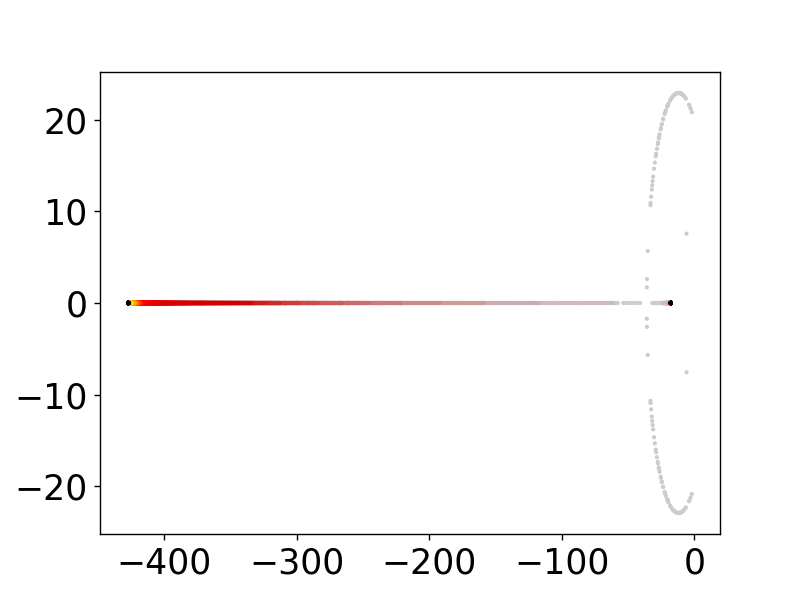

E*=0.0081, I*=0.0997: stable, with nonzero imaginary components


<IPython.core.display.Javascript object>


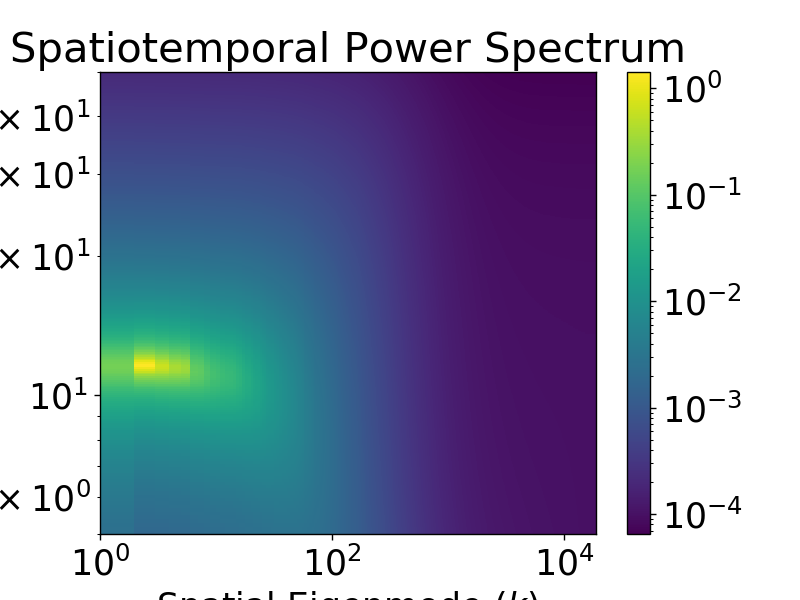

In [108]:
#thesis parameters
#better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00]))

#re-analyze result of minimization procedure
#better_result=np.load('decent_spatiotemporal_spectrum.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_even_lower_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lowest_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss_no_spatial_peak.npy')[()]

#maybe recent result (lower gauss no spatial peak alternative)
#better_result=dict(x=np.array([6.41977619e+02, 1.42531905e+02, 9.94882157e+02, 8.37385763e+01,
#       1.00000000e+02, 1.16561786e+01, 7.97871977e+00, 2.07583460e+00,
#       4.39673757e+00, 2.62815591e+00, 8.53315901e+00, 1.99778108e+02,
#       2.42307951e-01, 8.28123424e-01]))
#nice spatial, flat temporal. could be useful for differential evolution
#better_result=dict(x=np.array([130.31627133, 138.9154678 , 148.44650634, 143.0639378 ,
#        31.87944472,  21.29271631,   4.47605555,  26.50474072,
#         1.13733447,   1.03048892,  59.93085595,  70.21152403,
#         0.18327084,   6.35580065]))

better_result=result

SStates, success = H_Simple_Steady_State(alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], 
                                         d_e=better_result['x'][4], d_i=better_result['x'][5], P=better_result['x'][6], Q=better_result['x'][7])
print(SStates)       

SSnr=0

SStype, found_suitable, JacEigs = GraphWC_Jacobian_TrDet(Laplacian_eigenvalues=eigenvalues, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                     alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                     sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                     D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13], Visual=True)    


Spectrum = Graph_WC_Spatiotemporal_PowerSpectrum(Laplacian_eigenvalues=eigenvalues, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                        sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                        D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13],
                                        sigma_noise_e=1, sigma_noise_i=1,
                                        min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                        Spatial_Spectrum_Only=False, Visual=True)

Spectrum_spatial_only = Graph_WC_Spatiotemporal_PowerSpectrum(Laplacian_eigenvalues=eigenvalues, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                        sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                        D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13],
                                        sigma_noise_e=1, sigma_noise_i=1,
                                        min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                        Spatial_Spectrum_Only=True, Visual=False)
#FC=Functional_Connectivity(eigenvectors2, np.sum(Spectrum,axis=0), one_dim=False, Visual=False)


<IPython.core.display.Javascript object>


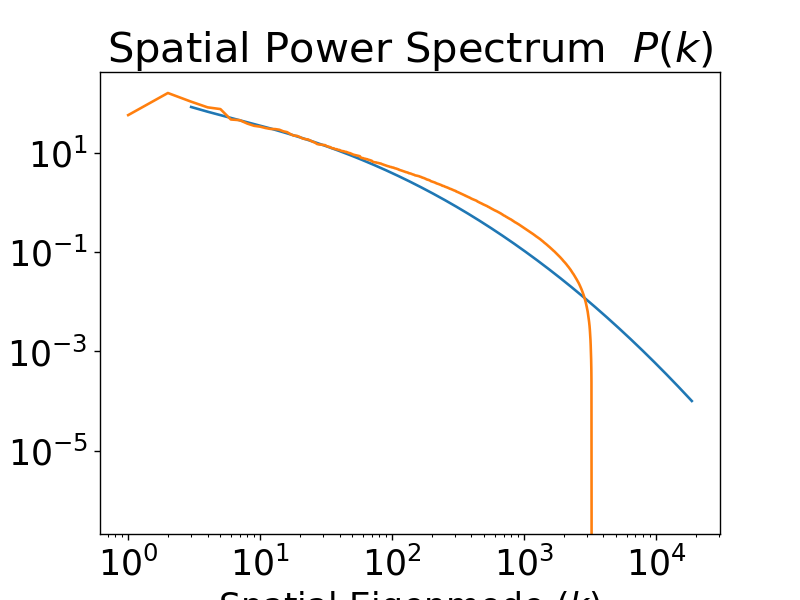

spatial scale factors: 59.35972020225002 -1.3174949933839573
spatial distance: 28.98423881113116


<IPython.core.display.Javascript object>


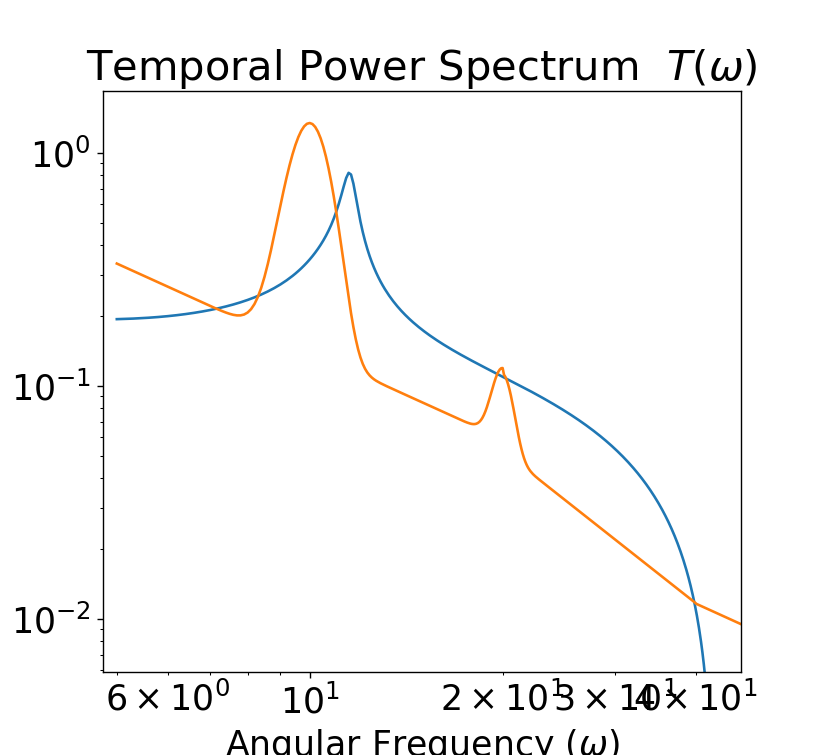

temporal scale factor: 0.08528653195934965 -0.2452776012467633
temporal distance: 3.7395829492849626
[[1.         0.61238221]
 [0.61238221 1.        ]]
[[1.         0.98924323]
 [0.98924323 1.        ]]


In [109]:
Gk=Spectrum_spatial_only[:,0,0] #Delta_omega*np.sum(Spectrum,axis=0)/np.pi
Gw=2*np.sum(Spectrum,axis=1)
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Spatial Power Spectrum  $P(k)$")
ax.set_xlabel("Spatial Eigenmode ($k$)")
true_SPS=True_Spatial_Spectrum

n_spatial = len(true_SPS)
current_spatial_spectrum = Gk[first_k:last_k]
a_spatial = (n_spatial*np.dot(current_spatial_spectrum,true_SPS)-np.sum(true_SPS)*np.sum(current_spatial_spectrum))/(n_spatial*np.dot(current_spatial_spectrum,current_spatial_spectrum)-np.sum(current_spatial_spectrum)**2)
b_spatial = (np.sum(true_SPS)-a_spatial*np.sum(current_spatial_spectrum))/n_spatial
this_spatial_distance = np.linalg.norm(true_SPS - a_spatial*current_spatial_spectrum-b_spatial, ord=2)

print("spatial scale factors: {} {}".format(a_spatial, b_spatial))

print("spatial distance: {}".format(this_spatial_distance))

ax.loglog(np.arange(first_k, last_k), true_SPS)
ax.loglog(np.arange(1,len(eigenvalues)+1), Gk*a_spatial+b_spatial)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title("Temporal Power Spectrum  $T(\omega)$")
ax.set_xlabel("Angular Frequency ($\omega$)")

freqs=np.arange(Min_omega,Max_omega,Delta_omega)/(2*np.pi)

true_TPS = True_Temporal_Spectrum
n_temporal = len(true_TPS)
current_temporal_spectrum = Gw
a_temporal = (n_temporal*np.dot(current_temporal_spectrum,true_TPS)-np.sum(true_TPS)*np.sum(current_temporal_spectrum))/(n_temporal*np.dot(current_temporal_spectrum,current_temporal_spectrum)-np.sum(current_temporal_spectrum)**2)
b_temporal = (np.sum(true_TPS)-a_temporal*np.sum(current_temporal_spectrum))/n_temporal
           
print("temporal scale factor: {} {}".format(a_temporal, b_temporal))
this_temporal_distance=np.linalg.norm(true_TPS-a_temporal*current_temporal_spectrum-b_temporal, ord=2)
print("temporal distance: {}".format(this_temporal_distance))

print(np.corrcoef(true_TPS, current_temporal_spectrum))
print(np.corrcoef(true_SPS, current_spatial_spectrum))

ax.loglog(freqs,
            current_temporal_spectrum*a_temporal +b_temporal)
ax.loglog(freqs, 
            true_TPS)

#np.save('decent_spatiotemporal_spectrum.npy', better_result)
#print(better_result)

In [111]:
#np.load('decent_spatiotemporal_spectrum_lower_gauss.npy')[()]['x']-better_result['x']

np.save('decent_spatiotemporal_spectrum_second_new_realistic.npy', result)


In [ ]:
#comparison of numerical (nonlinear) simulations and (linearized) semi analytic results 
#(any parameter set; grid laplacian only):
#
#1) test for steady state calculation: simulate (with no noise) on a grid, start directly from SS solution.
#2) test for stability/instability/oscillations: add noise in the grid simulation for specific parameter sets
#3) test for power spectrum calculation: run noisy grid simulation and compare prediction with measured PS (see handwritten notes)
#
################################################################################################
#testing the correctness of the parameter fit procedure(full analysis + minimization algorithm) result
#(intended mainly for the better_result parameter set)
#
#retest minimization algorithm, with objective the current best-fit PS obtained and random initial condition. see if other parameter combinations give the same, ideally converge to same par. set
#
#check (via effect on linearized Jk eigenvalues) if a nearby hopf bifurcation can be induced by changing P or some other parameter 
#(to ask rikkert: do we want this as a prior requirement in minimization? would be hard but doable)
#

<IPython.core.display.Javascript object>


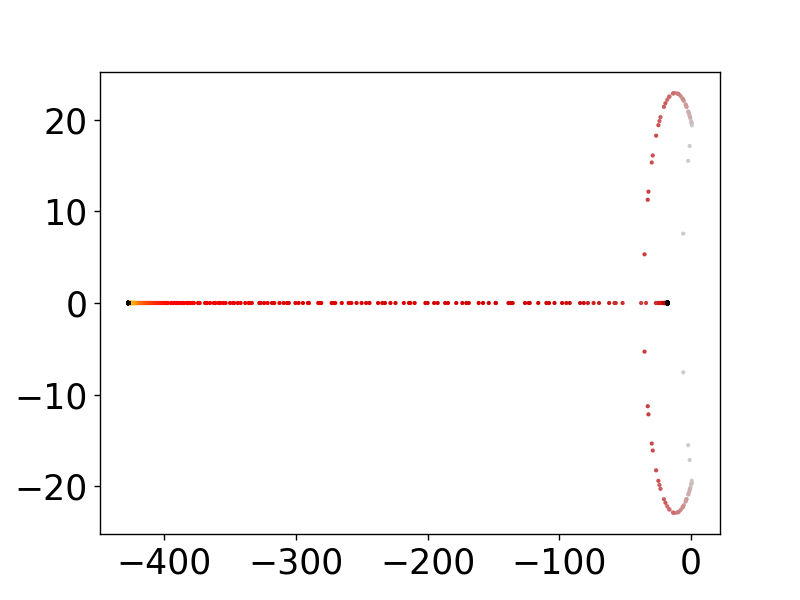

E*=0.0081, I*=0.0997: unstable


<IPython.core.display.Javascript object>


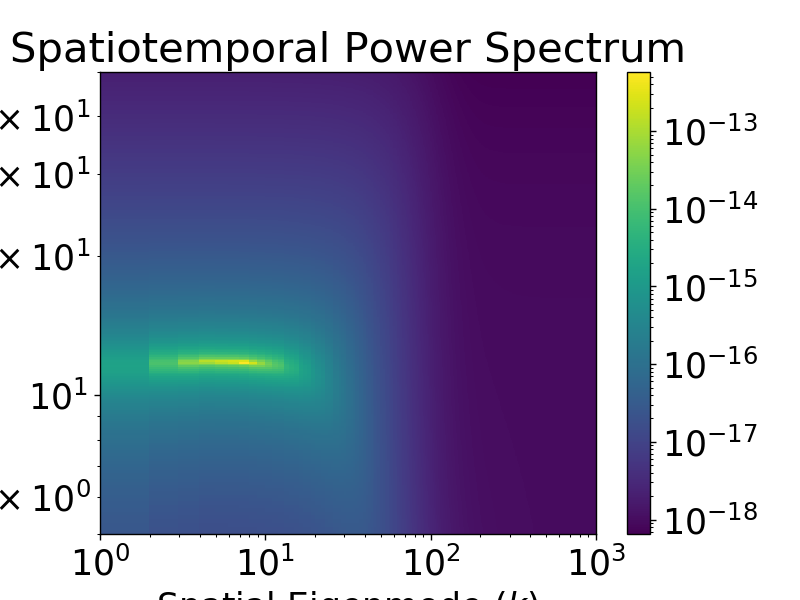

<IPython.core.display.Javascript object>


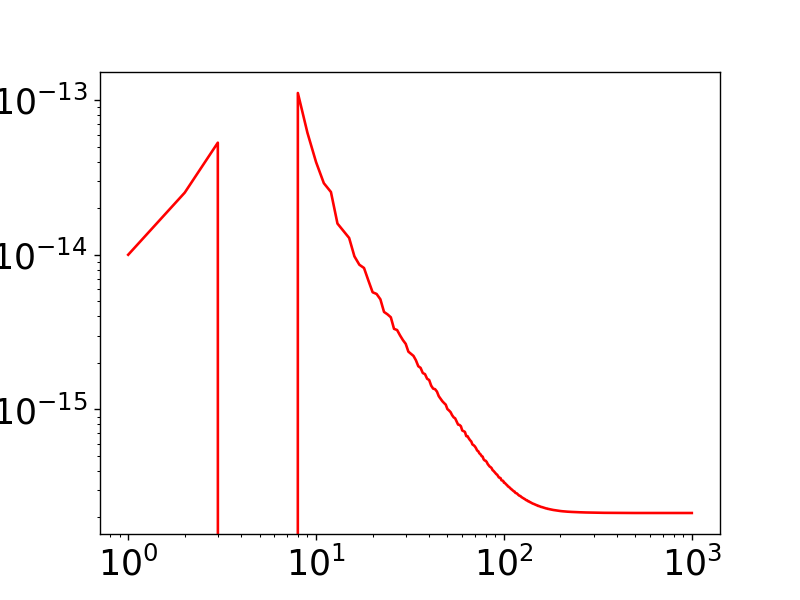

<IPython.core.display.Javascript object>


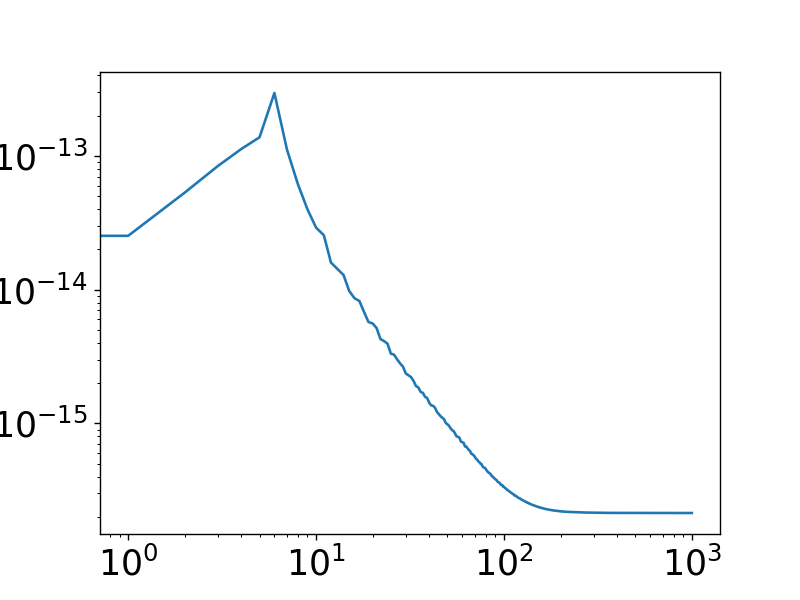

<IPython.core.display.Javascript object>


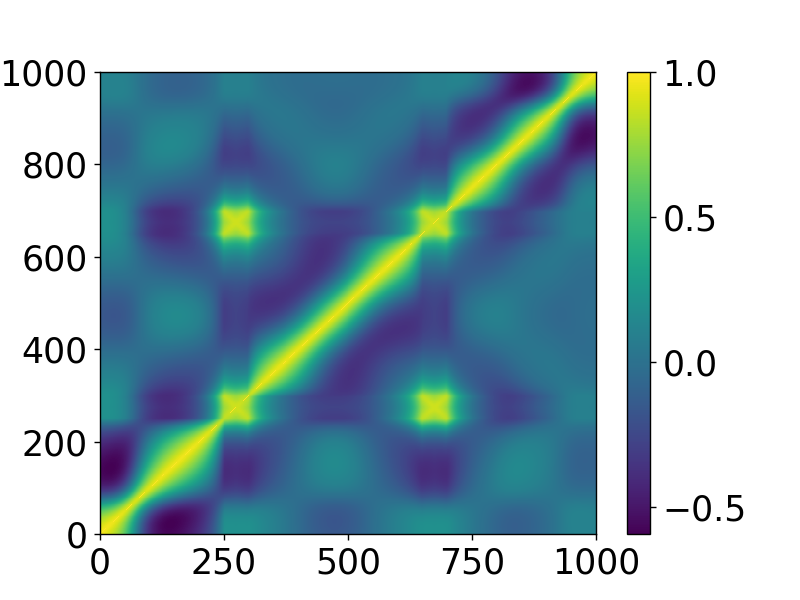

In [113]:
#1D predictions
#set up 1D-specific simulation parameters and WCM propagators
one_dim=False
syn=50
#if making plot from connectome minimization, need to change this value to the number of connectome nodes
gridsize=1000#len(eigenvalues)
h=1
Min_omega=5*(2*np.pi)
Max_omega=50*(2*np.pi)
Delta_omega=0.1*(2*np.pi)

Graph_Kernel='Gaussian'
one_dim_eigenvalues, one_dim_eigenvectors = one_dim_Laplacian_eigenvalues(gridsize, h, syn, vecs=True)
#one_dim_eigenvalues2 = one_dim_Laplacian_eigenvalues(gridsize, h, syn)

#re-analyze result of minimization procedure
#better_result=np.load('decent_spatiotemporal_spectrum.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_even_lower_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lowest_gauss.npy')[()]

#thesis result
#better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00]))

aEE=better_result['x'][0]
aIE=better_result['x'][1]
aEI=better_result['x'][2]
aII=better_result['x'][3]
dE=better_result['x'][4]
dI=better_result['x'][5]
P=better_result['x'][6]
Q=better_result['x'][7]
sEE=better_result['x'][8]
sIE=better_result['x'][9]
sEI=better_result['x'][10]
sII=better_result['x'][11]
D=1
tE=better_result['x'][12]
tI=better_result['x'][13]
snE=0.0000001
#snE=0.0001
snI=snE

#given parameters, calculate steady states
steady_states, success = H_Simple_Steady_State(aEE, aIE, aEI, aII, dE, dI, P, Q)


#for each steady state, compute linear stability and power spectrum
if success==True:
    nrSS=len(steady_states[0])
    allG = np.empty((nrSS,int((Max_omega-Min_omega)/Delta_omega),gridsize), dtype=float)
    SStypes=np.zeros(nrSS)
    for ss in range(nrSS):

        Ess = steady_states[0,ss]
        Iss = steady_states[1,ss]

        SStypes[ss], found_suitable, JacEigs = GraphWC_Jacobian_TrDet(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                         alpha_EE=aEE, alpha_IE=aIE, alpha_EI=aEI, alpha_II=aII, d_e=dE, d_i=dI,
                                         sigma_EE=sEE, sigma_IE=sIE, sigma_EI=sEI, sigma_II=sII, D=D, 
                                         tau_e=tE, tau_i=tI, Visual=True) 

        #allG[ss,:,:] = 
        allG[ss,:,:] =Graph_WC_Spatiotemporal_PowerSpectrum(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                                aEE, aIE, aEI, aII, dE, dI,
                                                 sEE, sIE, sEI, sII, D, 
                                                 tE, tI,
                                                 snE, snI, 
                                                  Min_omega, Max_omega, Delta_omega,          
                                                   Spatial_Spectrum_Only=False, Visual=True)
        
        sspectrum =Graph_WC_Spatiotemporal_PowerSpectrum(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                                aEE, aIE, aEI, aII, dE, dI,
                                                 sEE, sIE, sEI, sII, D, 
                                                 tE, tI,
                                                 snE, snI,         
                                                   Spatial_Spectrum_Only=True, Visual=True)
        
        fig=plt.figure()
        plt.loglog(np.abs(sspectrum[:,0,0]))
        
        Func_Conn_prediction = Functional_Connectivity(one_dim_eigenvectors, Delta_omega*np.sum(allG[ss,:,:], axis=0)/np.pi, one_dim=True, Visual=True)
        

        

In [114]:
#1D grid simulation (nonlinear wilson-cowan)
#thesis values
#Time=100
#Delta_t=0.01

#more recent param set values
#Time=3
#Delta_t=0.0001

#duration and timestep
Time=10
Delta_t=0.00005

#parameters of 1D graph (nonlocal synapses, grid size, grid spacing)
#syn=150
#gridsize=1000
#h=1

nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]    


E_total= Graph_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,                                  
                         one_dim=True, syn=syn, gridsize=gridsize, h=h,
                         Visual=False, SaveActivity=False, Filepath=' ')   


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
1720

29200
29210
29220
29230
29240
29250
29260
29270
29280
29290
29300
29310
29320
29330
29340
29350
29360
29370
29380
29390
29400
29410
29420
29430
29440
29450
29460
29470
29480
29490
29500
29510
29520
29530
29540
29550
29560
29570
29580
29590
29600
29610
29620
29630
29640
29650
29660
29670
29680
29690
29700
29710
29720
29730
29740
29750
29760
29770
29780
29790
29800
29810
29820
29830
29840
29850
29860
29870
29880
29890
29900
29910
29920
29930
29940
29950
29960
29970
29980
29990
30000
30010
30020
30030
30040
30050
30060
30070
30080
30090
30100
30110
30120
30130
30140
30150
30160
30170
30180
30190
30200
30210
30220
30230
30240
30250
30260
30270
30280
30290
30300
30310
30320
30330
30340
30350
30360
30370
30380
30390
30400
30410
30420
30430
30440
30450
30460
30470
30480
30490
30500
30510
30520
30530
30540
30550
30560
30570
30580
30590
30600
30610
30620
30630
30640
30650
30660
30670
30680
30690
30700
30710
30720
30730
30740
30750
30760
30770
30780
30790
30800
30810
30820
30830
30840
30850
3086

42870
42880
42890
42900
42910
42920
42930
42940
42950
42960
42970
42980
42990
43000
43010
43020
43030
43040
43050
43060
43070
43080
43090
43100
43110
43120
43130
43140
43150
43160
43170
43180
43190
43200
43210
43220
43230
43240
43250
43260
43270
43280
43290
43300
43310
43320
43330
43340
43350
43360
43370
43380
43390
43400
43410
43420
43430
43440
43450
43460
43470
43480
43490
43500
43510
43520
43530
43540
43550
43560
43570
43580
43590
43600
43610
43620
43630
43640
43650
43660
43670
43680
43690
43700
43710
43720
43730
43740
43750
43760
43770
43780
43790
43800
43810
43820
43830
43840
43850
43860
43870
43880
43890
43900
43910
43920
43930
43940
43950
43960
43970
43980
43990
44000
44010
44020
44030
44040
44050
44060
44070
44080
44090
44100
44110
44120
44130
44140
44150
44160
44170
44180
44190
44200
44210
44220
44230
44240
44250
44260
44270
44280
44290
44300
44310
44320
44330
44340
44350
44360
44370
44380
44390
44400
44410
44420
44430
44440
44450
44460
44470
44480
44490
44500
44510
44520
4453

56570
56580
56590
56600
56610
56620
56630
56640
56650
56660
56670
56680
56690
56700
56710
56720
56730
56740
56750
56760
56770
56780
56790
56800
56810
56820
56830
56840
56850
56860
56870
56880
56890
56900
56910
56920
56930
56940
56950
56960
56970
56980
56990
57000
57010
57020
57030
57040
57050
57060
57070
57080
57090
57100
57110
57120
57130
57140
57150
57160
57170
57180
57190
57200
57210
57220
57230
57240
57250
57260
57270
57280
57290
57300
57310
57320
57330
57340
57350
57360
57370
57380
57390
57400
57410
57420
57430
57440
57450
57460
57470
57480
57490
57500
57510
57520
57530
57540
57550
57560
57570
57580
57590
57600
57610
57620
57630
57640
57650
57660
57670
57680
57690
57700
57710
57720
57730
57740
57750
57760
57770
57780
57790
57800
57810
57820
57830
57840
57850
57860
57870
57880
57890
57900
57910
57920
57930
57940
57950
57960
57970
57980
57990
58000
58010
58020
58030
58040
58050
58060
58070
58080
58090
58100
58110
58120
58130
58140
58150
58160
58170
58180
58190
58200
58210
58220
5823

70240
70250
70260
70270
70280
70290
70300
70310
70320
70330
70340
70350
70360
70370
70380
70390
70400
70410
70420
70430
70440
70450
70460
70470
70480
70490
70500
70510
70520
70530
70540
70550
70560
70570
70580
70590
70600
70610
70620
70630
70640
70650
70660
70670
70680
70690
70700
70710
70720
70730
70740
70750
70760
70770
70780
70790
70800
70810
70820
70830
70840
70850
70860
70870
70880
70890
70900
70910
70920
70930
70940
70950
70960
70970
70980
70990
71000
71010
71020
71030
71040
71050
71060
71070
71080
71090
71100
71110
71120
71130
71140
71150
71160
71170
71180
71190
71200
71210
71220
71230
71240
71250
71260
71270
71280
71290
71300
71310
71320
71330
71340
71350
71360
71370
71380
71390
71400
71410
71420
71430
71440
71450
71460
71470
71480
71490
71500
71510
71520
71530
71540
71550
71560
71570
71580
71590
71600
71610
71620
71630
71640
71650
71660
71670
71680
71690
71700
71710
71720
71730
71740
71750
71760
71770
71780
71790
71800
71810
71820
71830
71840
71850
71860
71870
71880
71890
7190

83900
83910
83920
83930
83940
83950
83960
83970
83980
83990
84000
84010
84020
84030
84040
84050
84060
84070
84080
84090
84100
84110
84120
84130
84140
84150
84160
84170
84180
84190
84200
84210
84220
84230
84240
84250
84260
84270
84280
84290
84300
84310
84320
84330
84340
84350
84360
84370
84380
84390
84400
84410
84420
84430
84440
84450
84460
84470
84480
84490
84500
84510
84520
84530
84540
84550
84560
84570
84580
84590
84600
84610
84620
84630
84640
84650
84660
84670
84680
84690
84700
84710
84720
84730
84740
84750
84760
84770
84780
84790
84800
84810
84820
84830
84840
84850
84860
84870
84880
84890
84900
84910
84920
84930
84940
84950
84960
84970
84980
84990
85000
85010
85020
85030
85040
85050
85060
85070
85080
85090
85100
85110
85120
85130
85140
85150
85160
85170
85180
85190
85200
85210
85220
85230
85240
85250
85260
85270
85280
85290
85300
85310
85320
85330
85340
85350
85360
85370
85380
85390
85400
85410
85420
85430
85440
85450
85460
85470
85480
85490
85500
85510
85520
85530
85540
85550
8556

97570
97580
97590
97600
97610
97620
97630
97640
97650
97660
97670
97680
97690
97700
97710
97720
97730
97740
97750
97760
97770
97780
97790
97800
97810
97820
97830
97840
97850
97860
97870
97880
97890
97900
97910
97920
97930
97940
97950
97960
97970
97980
97990
98000
98010
98020
98030
98040
98050
98060
98070
98080
98090
98100
98110
98120
98130
98140
98150
98160
98170
98180
98190
98200
98210
98220
98230
98240
98250
98260
98270
98280
98290
98300
98310
98320
98330
98340
98350
98360
98370
98380
98390
98400
98410
98420
98430
98440
98450
98460
98470
98480
98490
98500
98510
98520
98530
98540
98550
98560
98570
98580
98590
98600
98610
98620
98630
98640
98650
98660
98670
98680
98690
98700
98710
98720
98730
98740
98750
98760
98770
98780
98790
98800
98810
98820
98830
98840
98850
98860
98870
98880
98890
98900
98910
98920
98930
98940
98950
98960
98970
98980
98990
99000
99010
99020
99030
99040
99050
99060
99070
99080
99090
99100
99110
99120
99130
99140
99150
99160
99170
99180
99190
99200
99210
99220
9923

Simulation SPS obtained.
Simulation TPS obtained.
All simulation activity measures completed.
Obtaining analytic predictions...


<IPython.core.display.Javascript object>


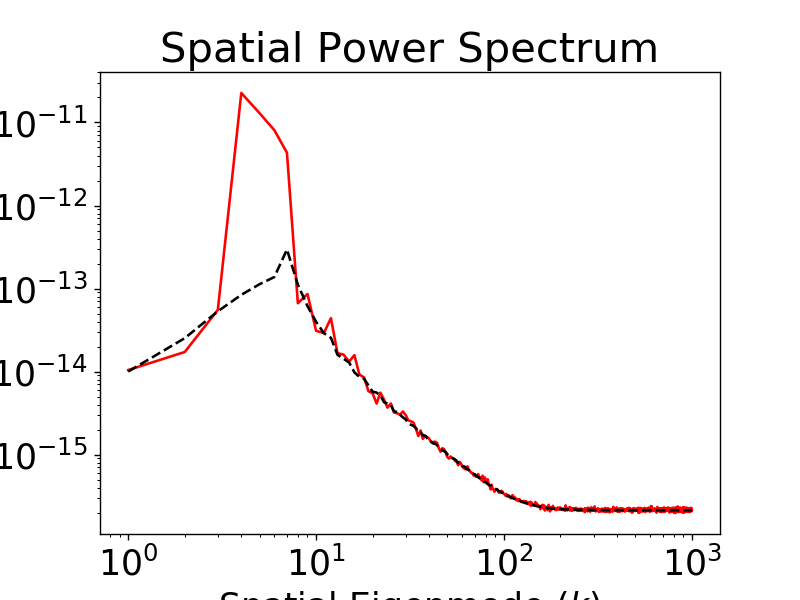

<IPython.core.display.Javascript object>


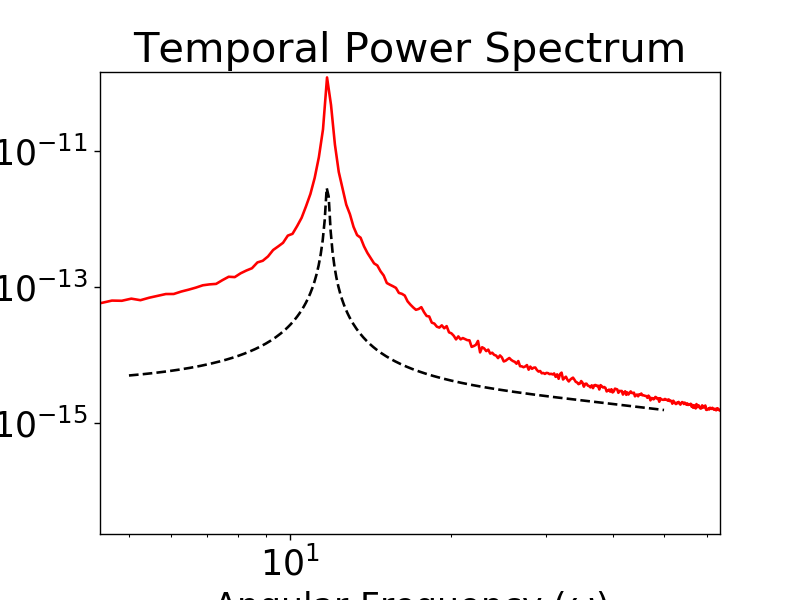

<IPython.core.display.Javascript object>


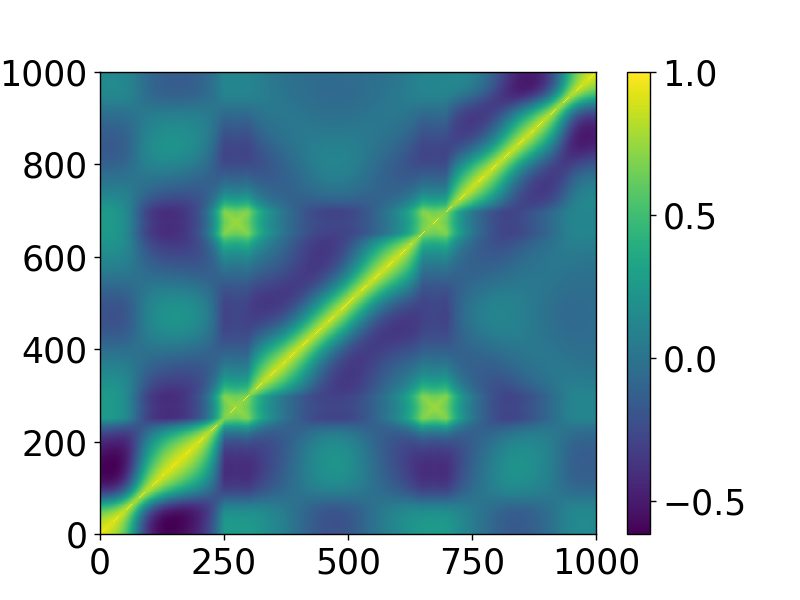

<IPython.core.display.Javascript object>


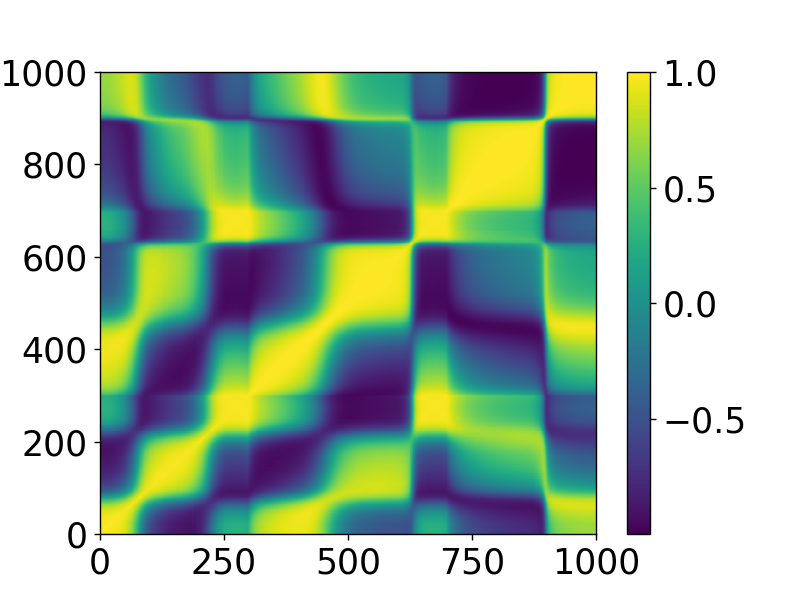

In [115]:
#activity analysis and comparison with prediction
#thesis values
#Max_omega=50
#Delta_omega=0.1

#Max_omega=5000
#Delta_omega=1

PS, TPS, FC = Activity_Analysis(Ess, Iss, Delta_t, 
                            aEE, aIE, aEI, aII,
                            sEE, sIE, sEI, sII, D,
                            dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,                             
                            beta=False, E_total=E_total,                                                      
                            prediction=True, min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,                        
                            one_dim=True, syn=syn, gridsize=gridsize, h=h,                           
                            Visual=True, Save_Results=False, Filepath=' ')


In [117]:
#Human connectome simulation (linearized wilson-cowan: perturbation about steady state)
#thesis time and timestep values
#Time=100
#Delta_t=0.01

Time=10
Delta_t=0.00005

nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]  


Beta_E_total = Linearized_GLDomain_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                         one_dim=False, eigvals=eigenvalues, eigvecs=None,
                         Visual=False, SaveActivity=False, Filepath=' ') 



MemoryError: 

In [ ]:
#activity analysis of linearized model and comparison with prediction (perturbation about steady state)
#thesis values
#Max_omega=50
#Delta_omega=0.1

Max_omega=2000
Delta_omega=1

PS_full, TPS_full = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                                
                                   beta=True, beta_E_total=Beta_E_total,
                                   
                                   prediction=True, max_omega=Max_omega, delta_omega=Delta_omega,
                                   
                                   one_dim=False, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=eigenvalues, eigvecs=None,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')


In [ ]:
##########################################################################################################

In [ ]:
#further verification: 1D grid simulation (linearized wilson-cowan: perturbation about steady state)

#duration and timestep
Time=3
Delta_t=0.00001

#parameters of 1D graph (nonlocal synapses, grid size, grid spacing)
syn=150
gridsize=1000
h=1

nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]   



Beta_E_total_1D = Linearized_GLDomain_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                         one_dim=True, syn=syn, gridsize=gridsize, h=h,
                         eigvals=None, eigvecs=None,
                         Visual=False, SaveActivity=False, Filepath=' ') 



In [ ]:
#activity analysis of linearized model and comparison with prediction (perturbation about steady state)
#thesis values
#Max_omega=50
#Delta_omega=0.1
plt.close('all')
Max_omega=3000
Delta_omega=0.5

PS_full_1D, TPS_full_1D = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                                
                                   beta=True, beta_E_total=Beta_E_total_1D,
                                   
                                   prediction=True, max_omega=Max_omega, delta_omega=Delta_omega,
                                   
                                   one_dim=True, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=None, eigvecs=None,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')


In [ ]:
#MISC
#Beta_E_total=np.load('G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.npy')
#del Beta_E_total
#del eigenvectors
#del connectome_activity
#np.save('G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.npy', Beta_E_total)
#print(len(Beta_E_total[0]))
#print(Beta_E_total[0])
with h5py.File("G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.h5") as hf:
    if "Activity" not in list(hf.keys()):
        #connectome_activity=np.dot(eigenvectors,Beta_E_total)
        hf.create_dataset("Activity",  data=connectome_activity)
    else:
        print("Warning: overwriting results of a previous simulation.") 

In [ ]:
#################******** PROPAGATOR TESTS ********#################

In [ ]:
#propagator test 1
#damped wave/telegrapher parameters
#params for first working tests: a=0.3, b=0.001, c=0, Delta_t=1, h=1 (worked with 2-normalized eigenvalues)
#make a smaller: wave travels faster
a=0.3
#make b larger: more diffusion
b=0.001
#nonzero c: switch from damped wave to telegrapher eqn
c=0

gridsize=1000
syn=0
h=1
u_0=0.3*sp.signal.gaussian(gridsize, 10)#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=100
#u_0[499]=1
u_final=graph_propagator_test(u_0, Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Damped Wave', a=a, b=b, c=c, sigma_noise=0.0,
                          one_dim=True, syn=syn, gridsize=gridsize,  h=h, eigvals=None, eigvecs=None,                         
                          Visual=True, SaveActivity=False, Filepath=' ', NSim=0)

In [ ]:
#propagator test 2
gridsize=1000
syn=0
h=1
u_0=np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=Delta_t
u_0[499]=400
#u_0=np.ones(gridsize)
u_final=graph_propagator_test(u_0, Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Gaussian', sigma_noise=0,
                          one_dim=True, syn=syn, gridsize=gridsize,  h=h, eigvals=None, eigvecs=None,                         
                          Visual=True, SaveActivity=False, Filepath=' ', NSim=0)
np.sum(u_final)

In [ ]:
#propagator test 3: cortical mesh
#damped wave/telegrapher parameters
#params for first working tests: a=0.3, b=0.001, c=0, Delta_t=1
#make a smaller: wave travels faster
a=0.3
#make b larger: more diffusion
b=0.005
#nonzero c: switch from damped wave to telegrapher eqn
c=0

u_0=np.zeros(len(eigenvalues))#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=1000
u_0[6369]=50
u_0=graph_propagator_test(u_0, Time=50, Delta_t=50, kernel_param=50, Graph_Kernel='Gaussian', sigma_noise=0.0,
                          one_dim=False, syn=0, gridsize=0,  h=0, eigvals=eigenvalues, eigvecs=eigenvectors,                         
                          Visual=False, SaveActivity=False, Filepath=' ', NSim=0)
u_final=graph_propagator_test(u_0, Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Damped Wave', a=a, b=b, c=c, sigma_noise=0.0,
                          one_dim=False, syn=0, gridsize=0,  h=0, eigvals=eigenvalues, eigvecs=eigenvectors,                         
                          Visual=False, SaveActivity=True, Filepath=' ', NSim=0)

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
f = h5py.File('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
indices = np.array([elem[0] for elem in CC])-1
AllVet=np.asarray(f['vertices']['all'])
AllVet=AllVet[:,indices]

dist=np.sqrt(AllVet[0,:]**2 + AllVet[1,:]**2 + AllVet[2,:]**2)
trace4 = go.Scatter3d(
    x=AllVet[0,:],
    y=AllVet[1,:],
    z=AllVet[2,:],
    #alphahull=50
    mode='markers',
    marker=dict(
        size=5,
        color=dist,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1,
        #line=dict(color='rgba(0, 0, 0,0.5)',width=1,)
        )
    )
data = [trace3]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [ ]:
with h5py.File('G:/Macbook Stuff/Simulation Results/Damped Wave Kernel Test t=1/0# Sim Activity b=0.005.h5', 'r') as file:
    print(list(file.keys()))
    DWave = np.asarray(file['Activity'], dtype=float)

DWave[:,0]

In [ ]:
np.max(DWave[:,60])

In [ ]:
import plotly.offline as offline
from plotly.graph_objs import *
#init_notebook_mode(connected=True)
offline.init_notebook_mode()

#mesh (or full connectome) graph edges
#trace1=Scatter3d(x=Xe,
#               y=Ye,
#               z=Ze,
#               mode='lines',
#              line=Line(color='rgba(0,0,0,1)', width=1),
#             )

#Mesh3d
trace2=Mesh3d(x=Xn,
               y=Yn,
               z=Zn,
              i=iN,
              j=jN,
              k=kN,
              text=np.arange(len(Xn)),
              intensity=DWave[:,0],
             lighting = dict(ambient=0.8, diffuse=1, roughness = 0.4, specular=0, fresnel=0.2)#,
              #cmin=-10E-9,#-0.1,
              #cmax=10E-9#0.1
              #eigenvectors[:,1001]#
              
            #, lighting=dict(ambient=,
                        #diffuse=,
                 #specular=,
                 #roughness=,
                 #fresnel=)
              
          #     mode='markers',
          #  marker=dict(
          #          size=5,
          #          color=-AllVet[1,:],#np.sqrt(AllVet[2,:]**2+AllVet[0,:]**2+AllVet[1,:]**2),                # set color to an array/list of desired values
          #          colorscale='Viridis',   # choose a colorscale
          #          opacity=0.8,
          #          line=dict(color='rgba(0, 0, 0,0.5)',
          #                     width=1,
        #                     )
        #                )
                )



frames =[dict(data=[dict(type='mesh3d', intensity=DWave[:,i])],
                  traces=[0],
                  name='frame{}'.format(i)) for i in range(0,150,3)] 




axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )
                 
layout = Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),  
    hovermode=False,     autosize=False,
    width=1000,
    height=700
)       
data=Data([trace2])

fig_frames = Figure(data=data, layout=layout, frames=frames)

fig_frames['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 250, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 120, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}], 
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': True,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

#fig=Figure(data=data, layout=layout)

offline.iplot(fig_frames, filename='Les-Miserables')

In [ ]:
with h5py.File('G:/Macbook Stuff/Downloads/Fibers.mat', 'r') as file:
    print(list(file.keys()))
    print(list(file['fgCC'].keys()))
        
    Fibers=[file[element][:] for element in file['fgCC']['fibers'][0]]

fiber_edges=np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/fgCC_fiber_edges.npy')
f = h5py.File('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
f.close()
indices = np.array([elem[0] for elem in CC])-1
EX=[]
EY=[]
EZ=[]
colors=[]

counter=0
for i in range(0,len(Fibers),2):
    if fiber_edges[i,0] in indices and fiber_edges[i,1] in indices and fiber_edges[i,0]!=fiber_edges[i,1]:
        counter+=1
        for j in range(Fibers[i].shape[0]-1):
            EX+=[Fibers[i][j,0], Fibers[i][j+1,0], None]
            EY+=[Fibers[i][j,1], Fibers[i][j+1,1], None]
            EZ+=[Fibers[i][j,2], Fibers[i][j+1,2], None]

counter    


    

In [ ]:
import plotly.offline as offline
from plotly.graph_objs import *
#init_notebook_mode(connected=True)
offline.init_notebook_mode()

trace3=Scatter3d(x=EX,
               y=EY,
               z=EZ,
               mode='lines',
               line=Line(color=EX,#'rgba(100,100,100,0.9)',#colors
                         #colorscale=[[0, 'rgb(0,0,255)'], [1, 'rgb(255,0,0)']],#'Rainbow',
                         width=1),
               )
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )
                 
layout = Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
    hovermode=False
)       
data=Data([trace3])
fig=Figure(data=data, layout=layout)

offline.iplot(fig, filename='Les-Miserables-2')